In [1]:
import copy
import torch
import argparse
import numpy as np
import umap
from torchvision import datasets, transforms
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, f1_score, roc_auc_score, roc_curve, matthews_corrcoef as mcc
from torch.utils.data import Subset
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import numbers
import torch.nn as nn
# from cac import batch_cac
# from kmeans import batch_KMeans
from meanshift import batch_MeanShift
from autoencoder import AutoEncoder
from sklearn.metrics import davies_bouldin_score as dbs, adjusted_rand_score as ari
from matplotlib import pyplot as plt
color = ['grey', 'red', 'blue', 'pink', 'brown', 'black', 'magenta', 'purple', 'orange', 'cyan', 'olive']

In [2]:
## k-Means
def _parallel_compute_distance(X, cluster):
    n_samples = X.shape[0]
    dis_mat = np.zeros((n_samples, 1))
    for i in range(n_samples):
        dis_mat[i] += np.sqrt(np.sum((X[i] - cluster) ** 2, axis=0))
    return dis_mat


class batch_KMeans(object):
    def __init__(self, args):
        self.args = args
        self.latent_dim = args.latent_dim
        self.n_clusters = args.n_clusters
        self.clusters = np.zeros((self.n_clusters, self.latent_dim))
        self.count = 100 * np.ones((self.n_clusters))  # serve as learning rate
        self.n_jobs = args.n_jobs
        self.positive_centers = np.zeros((self.n_clusters, self.latent_dim))
        self.negative_centers = np.zeros((self.n_clusters, self.latent_dim))
        self.cluster_stats = np.zeros((self.n_clusters,2))

    
    def _compute_dist(self, X):
        dis_mat = Parallel(n_jobs=self.n_jobs)(
            delayed(_parallel_compute_distance)(X, self.clusters[i])
            for i in range(self.n_clusters))
        dis_mat = np.hstack(dis_mat)
        
        return dis_mat


    def init_cluster(self, X, y=None, indices=None):
        """ Generate initial clusters using sklearn.Kmeans """
        model = KMeans(n_clusters=self.n_clusters,
                       n_init=20)
        model.fit(X)
        self.clusters = model.cluster_centers_  # copy clusters
        labels = model.labels_

        for j in range(self.n_clusters):
            pts_index = np.where(labels == j)[0]
            cluster_pts = X[pts_index]        
            n_class_index = np.where(y[pts_index] == 0)[0]
            p_class_index = np.where(y[pts_index] == 1)[0]

            self.cluster_stats[j][0] = len(p_class_index)
            self.cluster_stats[j][1] = len(n_class_index)

            n_class = cluster_pts[n_class_index]
            p_class = cluster_pts[p_class_index]

            self.negative_centers[j,:] = n_class.mean(axis=0)
            self.positive_centers[j,:] = p_class.mean(axis=0)


    def update_cluster(self, X, cluster_idx):
        """ Update clusters in Kmeans on a batch of data """
        n_samples = X.shape[0]
        for i in range(n_samples):
            self.count[cluster_idx] += 1
            eta = 1.0 / self.count[cluster_idx]
            updated_cluster = ((1 - eta) * self.clusters[cluster_idx] + 
                               eta * X[i])
            self.clusters[cluster_idx] = updated_cluster
    

    def update_assign(self, X, y=None):
        """ Assign samples in `X` to clusters """
        dis_mat = self._compute_dist(X)
        new_labels = np.argmin(dis_mat, axis=1)

        if y is not None:
            for j in range(self.n_clusters):
                pts_index = np.where(new_labels == j)[0]
                cluster_pts = X[pts_index]        
                n_class_index = np.where(y[pts_index] == 0)[0]
                p_class_index = np.where(y[pts_index] == 1)[0]

                self.cluster_stats[j][0] = len(p_class_index)
                self.cluster_stats[j][1] = len(n_class_index)

                n_class = cluster_pts[n_class_index]
                p_class = cluster_pts[p_class_index]

                self.negative_centers[j,:] = n_class.mean(axis=0)
                self.positive_centers[j,:] = p_class.mean(axis=0)

        return new_labels

In [61]:
import numpy as np
from sklearn.cluster import KMeans
from joblib import Parallel, delayed
from cac_main import specificity, sensitivity, best_threshold, cac,\
compute_euclidean_distance, calculate_gamma_old, calculate_gamma_new
import umap
from matplotlib import pyplot as plt
from sklearn.metrics import adjusted_rand_score as ari

class batch_cac(object):    
    def __init__(self, args):
        self.args = args
        self.latent_dim = args.latent_dim
        self.n_clusters = args.n_clusters
        self.cluster_stats = np.zeros((self.n_clusters,2))
        self.clusters = np.zeros((self.n_clusters, self.latent_dim))
        self.positive_centers = np.zeros((self.n_clusters, self.latent_dim))
        self.negative_centers = np.zeros((self.n_clusters, self.latent_dim))
        self.count = 100 * np.ones((self.n_clusters))  # serve as learning rate
        self.n_jobs = args.n_jobs


    def predict_clusters(self, X_test, centers) -> np.array:
        K = centers.shape[0]
        dists = np.zeros(K)
        test_labels = np.zeros(X_test.shape[0])

        for pt in range(X_test.shape[0]):
            for k in range(K):
                min_dist = np.square(np.linalg.norm(centers[k] - X_test[pt]))
                dists[k] = min_dist
            test_labels[pt] = int(np.argmin(dists))
        return test_labels.astype(int)


    def update_cluster_centers(self, X, y, cluster_labels):
        for j in range(self.n_clusters):
            pts_index = np.where(cluster_labels == j)[0]
            cluster_pts = X[pts_index]        
            for pt in pts_index:
                self.count[j] += 1
                eta = 1/(self.count[j])
#                 eta = 1/(self.cluster_stats[j])
                self.clusters[j,:] = (1-eta)*self.clusters[j,:] + eta*X[pt]

                if y[pt] == 0:
                    self.negative_centers[j,:] = (1-eta)*self.negative_centers[j,:] +\
                                                    eta*X[pt]
                else:
                    self.positive_centers[j,:] = (1-eta)*self.positive_centers[j,:] +\
                                                    eta*X[pt]

            n_class_index = np.where(y[pts_index] == 0)[0]
            p_class_index = np.where(y[pts_index] == 1)[0]

#             self.cluster_stats[j][0] = len(p_class_index)
#             self.cluster_stats[j][1] = len(n_class_index)

        return None


    def update(self, X, y, cluster_stats, labels, centers, positive_centers, negative_centers, k, beta, alpha):
        total_iterations = 100
        errors = np.zeros((total_iterations, k))
        lbls = []
        lbls.append(np.copy(labels))
        
        if len(np.unique(y)) == 1:
            return cluster_stats, labels, centers, positive_centers, negative_centers
        
        old_p, old_n = np.copy(positive_centers), np.copy(negative_centers)
        
        for iteration in range(total_iterations):
            N = len(X)
            cluster_label = []
            for index_point in range(N):
                distance = {}
                pt = X[index_point]
                pt_label = y[index_point]
                cluster_id = labels[index_point]
                p, n = cluster_stats[cluster_id][0], cluster_stats[cluster_id][1]
                new_cluster = old_cluster = labels[index_point]
                old_err = np.zeros(k)
#                 print(alpha, p, n, pt_label, (p > 1 and pt_label == 1))
                # Ensure that degeneracy is not happening
                if ((p > 1 and pt_label == 1) or (n > 1 and pt_label == 0)):
#                     print("CAC Bool condition fulfilled")
                    for cluster_id in range(0, k):
                        if cluster_id != old_cluster:
                            distance[cluster_id] = calculate_gamma_new(pt, pt_label, centers[cluster_id],\
                                                    positive_centers[cluster_id], negative_centers[cluster_id],\
                                                    cluster_stats[cluster_id], beta, alpha)
                        else:
                            distance[cluster_id] = np.infty

                    old_gamma = calculate_gamma_old(pt, pt_label, centers[old_cluster],\
                                                    positive_centers[old_cluster], negative_centers[old_cluster],\
                                                    cluster_stats[old_cluster], beta, alpha)
                    # new update condition
                    new_cluster = min(distance, key=distance.get)
                    new_gamma = distance[new_cluster]

                    if old_gamma + new_gamma < 0:
#                         print("CAC update fulfilled, pt_label = ", pt_label)
                        # Remove point from old cluster
                        p, n = cluster_stats[old_cluster] # Old cluster statistics
                        t = p + n

                        centers[old_cluster] = (t/(t-1))*centers[old_cluster] - (1/(t-1))*pt
                        o_n = np.copy(negative_centers[old_cluster])
                        o_p = np.copy(positive_centers[old_cluster])
                        
                        if pt_label == 0:
                            negative_centers[old_cluster] = (n/(n-1))*negative_centers[old_cluster] - (1/(n-1)) * pt
                            cluster_stats[old_cluster][1] -= 1

                        else:
                            positive_centers[old_cluster] = (p/(p-1))*positive_centers[old_cluster] - (1/(p-1)) * pt
                            cluster_stats[old_cluster][0] -= 1
                        
#                         print("w/i loop mean diff")
#                         print(np.mean(o_p-positive_centers[old_cluster]), np.mean(o_n - negative_centers[old_cluster]))

                        # Add point to new cluster
                        p, n = cluster_stats[new_cluster] # New cluster statistics
                        t = p + n
                        centers[new_cluster] = (t/(t+1))*centers[new_cluster] + (1/(t+1))*pt

                        if pt_label == 0:
                            negative_centers[new_cluster] = (n/(n+1))*negative_centers[new_cluster] + (1/(n+1)) * pt
                            cluster_stats[new_cluster][1] += 1

                        else:
                            positive_centers[new_cluster] = (p/(p+1))*positive_centers[new_cluster] + (1/(p+1)) * pt
                            cluster_stats[new_cluster][0] += 1
                        labels[index_point] = new_cluster
                        assert(cluster_stats[old_cluster][0] > 0)
                        assert(cluster_stats[old_cluster][1] > 0)

            lbls.append(np.copy(labels))
            if ((lbls[iteration] == lbls[iteration-1]).all()) and iteration > 0:
                print("converged at itr: ", iteration)
                break

#         print("Mean of Delta Clusters")
#         print(np.mean(old_p-positive_centers), np.mean(old_n - negative_centers))

        return cluster_stats, labels, centers, positive_centers, negative_centers

    
    def cluster(self, X, y, beta, alpha):
        # Update assigned cluster labels to points
        cluster_labels = self.predict_clusters(X, self.clusters)
#         print("Before centers")
#         print(np.sum(self.positive_centers), np.sum(self.negative_centers))

        # Do we need this really? ... yes
        self.update_cluster_centers(X, y, cluster_labels)

        # update cluster centers
        self.cluster_stats, new_labels, self.clusters, self.positive_centers, self.negative_centers = self.update(X, y, self.cluster_stats, cluster_labels,\
             self.clusters, self.positive_centers, self.negative_centers, self.n_clusters, beta, alpha)

#         print("After centers")
#         print(np.sum(self.positive_centers), np.sum(self.negative_centers))

        return new_labels
    

    def init_cluster(self, X, y, indices=None):
        """ Generate initial clusters using sklearn.Kmeans """
        """ X will be AE embeddings """
        model = KMeans(n_clusters=self.n_clusters,
                       n_init=20)
        model.fit(X)
        self.clusters = model.cluster_centers_  # copy clusters
        labels = model.labels_

        for j in range(self.n_clusters):
            pts_index = np.where(labels == j)[0]
            cluster_pts = X[pts_index]
#             assert(np.allclose(self.clusters[j,:], cluster_pts.mean(axis=0)))
            n_class_index = np.where(y[pts_index] == 0)[0]
            p_class_index = np.where(y[pts_index] == 1)[0]

            self.cluster_stats[j][0] = len(p_class_index)
            self.cluster_stats[j][1] = len(n_class_index)

            n_class = cluster_pts[n_class_index]
            p_class = cluster_pts[p_class_index]

            self.negative_centers[j,:] = n_class.mean(axis=0)
            self.positive_centers[j,:] = p_class.mean(axis=0)

        # self.clusters = np.random.rand(self.n_clusters, self.latent_dim)  # copy clusters

    def update_assign(self, X, target=None):
        """ Assign samples in `X` to clusters """
        return self.predict_clusters(X, self.clusters)

In [53]:
def get_dataset(DATASET, base_dir):
    if DATASET == "cic":
        Xa = pd.read_csv(base_dir + "/CIC/cic_set_a.csv")
        Xb = pd.read_csv(base_dir + "/CIC/cic_set_b.csv")
        Xc = pd.read_csv(base_dir + "/CIC/cic_set_c.csv")

        ya = Xa['In-hospital_death']
        yb = Xb['In-hospital_death']
        yc = Xc['In-hospital_death']

        Xa = Xa.drop(columns=['recordid', 'Survival', 'In-hospital_death'])
        Xb = Xb.drop(columns=['recordid', 'Survival', 'In-hospital_death'])
        Xc = Xc.drop(columns=['recordid', 'Survival', 'In-hospital_death'])

        cols = Xa.columns

        scale = StandardScaler()
        Xa = scale.fit_transform(Xa)
        Xb = scale.fit_transform(Xb)
        Xc = scale.fit_transform(Xc)

        Xa = pd.DataFrame(Xa, columns=cols)
        Xb = pd.DataFrame(Xb, columns=cols)
        Xc = pd.DataFrame(Xc, columns=cols)

        Xa = Xa.fillna(0)
        Xb = Xb.fillna(0)
        Xc = Xc.fillna(0)

        X_train = pd.concat([Xa, Xb])
        y_train = pd.concat([ya, yb])

        X_test = Xc
        y_test = yc

        X = pd.concat([X_train, X_test]).to_numpy()
        y = pd.concat([y_train, y_test]).to_numpy()

    elif DATASET == "titanic":
        X_train = pd.read_csv(base_dir + "/" + DATASET + "/" + "X_train.csv").to_numpy()
        X_test = pd.read_csv(base_dir + "/" + DATASET + "/" + "X_test.csv").to_numpy()
        y_train = pd.read_csv(base_dir + "/" + DATASET + "/" + "y_train.csv").to_numpy()
        y_test = pd.read_csv(base_dir + "/" + DATASET + "/" + "y_test.csv").to_numpy()

        X = np.vstack([X_train, X_test])
        y = np.vstack([y_train, y_test])
        # X = pd.concat([X_train, X_test]).to_numpy()
        # y = pd.concat([y_train, y_test]).to_numpy()

    else:
        X = pd.read_csv(base_dir + "/" + DATASET + "/" + "X.csv").to_numpy()
        y = pd.read_csv(base_dir + "/" + DATASET + "/" + "y.csv").to_numpy()

    y1 = []
    for i in range(len(y)):
        y1.append(y[i])
    y = np.array(y)
    return X, y

In [79]:
import torch
import numbers
import numpy as np
import torch.nn as nn
# from cac import batch_cac
# from kmeans import batch_KMeans
from meanshift import batch_MeanShift
from autoencoder import AutoEncoder
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import davies_bouldin_score as dbs, adjusted_rand_score as ari
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, RidgeClassifier
from matplotlib import pyplot as plt

color = ['grey', 'red', 'blue', 'pink', 'brown', 'black', 'magenta', 'purple', 'orange', 'cyan', 'olive']

class DCN(nn.Module):
    def __init__(self, args):
        super(DCN, self).__init__()
        self.args = args
        self.beta = args.beta  # coefficient of the clustering term
        #print("k-Means pretraining")
        self.lamda = args.lamda  # coefficient of the reconstruction term
        self.device = torch.device(args.device)
        
        # Validation check
        if not self.beta > 0:
            msg = 'beta should be greater than 0 but got value = {}.'
            raise ValueError(msg.format(self.beta))
        
        if not self.lamda > 0:
            msg = 'lamda should be greater than 0 but got value = {}.'
            raise ValueError(msg.format(self.lamda))
        
        if len(self.args.hidden_dims) == 0:
            raise ValueError('No hidden layer specified.')
        print(args.clustering)
        if args.clustering == 'kmeans':
            self.clustering = batch_KMeans(args)
        elif args.clustering == 'meanshift':
            self.clustering = batch_MeanShift(args)
        elif args.clustering == "cac":
            self.clustering = batch_cac(args)
            self.classifier = args.classifier
            self.cluster_classifiers = []
            self.base_classifier = []
        else:
            raise RuntimeError('Error: no clustering chosen')
            
        self.autoencoder = AutoEncoder(args).to(self.device)
        self.criterion  = nn.MSELoss(reduction='sum')
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=args.lr,
                                          weight_decay=args.wd)
    
    def get_classifier(self, classifier):
        if classifier == "LR":
            model = LogisticRegression(random_state=0, max_iter=1000)
        elif classifier == "RF":
            model = RandomForestClassifier(n_estimators=10)
        elif classifier == "SVM":
            # model = SVC(kernel="linear", probability=True)
            model = LinearSVC(max_iter=5000)
            model.predict_proba = lambda X: np.array([model.decision_function(X), model.decision_function(X)]).transpose()
        elif classifier == "Perceptron":
            model = Perceptron()
            model.predict_proba = lambda X: np.array([model.decision_function(X), model.decision_function(X)]).transpose()
        elif classifier == "ADB":
            model = AdaBoostClassifier(n_estimators = 100)
        elif classifier == "DT":
            model = DecisionTreeClassifier()
        elif classifier == "LDA":
            model = LDA()
        elif classifier == "NB":
            model = MultinomialNB()
        elif classifier == "SGD":
            model = SGDClassifier(loss='log')
        elif classifier == "Ridge":
            model = RidgeClassifier()
            model.predict_proba = lambda X: np.array([model.decision_function(X), model.decision_function(X)]).transpose()
        elif classifier == "KNN":
            model = KNeighborsClassifier(n_neighbors=5)
        else:
            model = LogisticRegression(class_weight='balanced', max_iter=1000)
        return model

    """ Compute the Equation (5) in the original paper on a data batch """
    def _loss(self, X, cluster_id):
        batch_size = X.size()[0]
        rec_X = self.autoencoder(X)
        latent_X = self.autoencoder(X, latent=True)
        
        # Reconstruction error
        rec_loss = self.lamda * self.criterion(X, rec_X)
        
        # Regularization term on clustering
        km_loss = torch.tensor(0.).to(self.device)
        sep_loss = torch.tensor(0.).to(self.device)
        clusters = torch.FloatTensor(self.clustering.clusters).to(self.device)
        positive_clusters = torch.FloatTensor(self.clustering.positive_centers).to(self.device)
        negative_clusters = torch.FloatTensor(self.clustering.negative_centers).to(self.device)

        for i in range(batch_size):
            diff_vec = latent_X[i] - clusters[cluster_id[i]]
            sample_dist_loss = torch.matmul(diff_vec.view(1, -1),
                                            diff_vec.view(-1, 1))
            km_loss += 0.5 * self.beta * torch.squeeze(sample_dist_loss)
            
            if self.args.clustering == "cac":
                diff_vec = positive_clusters[cluster_id[i]] - negative_clusters[cluster_id[i]]
                sample_sep_loss = torch.matmul(diff_vec.view(1, -1),
                                                diff_vec.view(-1, 1))
                sep_loss -= np.log(self.args.alpha * torch.squeeze(sample_sep_loss))
        
        for j in range(self.args.n_clusters):
            diff_vec = positive_clusters[j] - negative_clusters[j]
            sample_sep_loss = torch.matmul(diff_vec.view(1, -1),
                                            diff_vec.view(-1, 1))
            sample_sep_loss = torch.squeeze(sample_sep_loss)
            print("Class Dist: ", np.log(sample_sep_loss))

        print("KM Dist: ", km_loss)
        print("Sep Dist: ", sep_loss)

        return (rec_loss + km_loss + sep_loss,
                rec_loss.detach().cpu().numpy(),
                (km_loss + sep_loss).detach().cpu().numpy())
    
    def pretrain(self, train_loader, epoch=100, verbose=True):
        if not self.args.pretrain:
            return
        
        if not isinstance(epoch, numbers.Integral):
            msg = '`epoch` should be an integer but got value = {}'
            raise ValueError(msg.format(epoch))
        
        if verbose:
            print('========== Start pretraining ==========')
        
        rec_loss_list = []
        
        self.train()
        for e in range(epoch):
            for batch_idx, (data, _) in enumerate(train_loader):
                batch_size = data.size()[0]
                data = data.to(self.device).view(batch_size, -1)
                rec_X = self.autoencoder(data)
                loss = self.criterion(data, rec_X)
                if verbose and (batch_idx+1) % self.args.log_interval == 0:
                    msg = 'Epoch: {:02d} | Batch: {:03d} | Rec-Loss: {:.3f}'
                    print(msg.format(e, batch_idx+1, 
                                     loss.detach().cpu().numpy()))
                    rec_loss_list.append(loss.detach().cpu().numpy())
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
        self.eval()
        
        if verbose:
            print('========== End pretraining ==========\n')

        self.pre_cluster(train_loader)
                
        return rec_loss_list


    def pre_cluster(self, train_loader):
        # Initialize clusters in self.clustering after pre-training
        batch_X = []
        batch_y = []
        for batch_idx, (data, y) in enumerate(train_loader):
            batch_size = data.size()[0]
            data = data.to(self.device).view(batch_size, -1)
            latent_X = self.autoencoder(data, latent=True)
            batch_X.append(latent_X.detach().cpu().numpy())
            batch_y.extend(y.detach().cpu().numpy())

        batch_X = np.vstack(batch_X)
        batch_y = np.array(batch_y)

        self.clustering.init_cluster(batch_X, batch_y)
        return None


    def fit(self, epoch, train_loader, verbose=True):
        X_train = []
        y_train = []
        cluster_ids_train = []
        for batch_idx, (data, y) in enumerate(train_loader):
            batch_size = data.size()[0]
            data = data.view(batch_size, -1).to(self.device)

            # Collect training data and labels for the later classifier
            X_train.append(data)
            y_train.extend(y.numpy())
            
            # Get the latent features
            with torch.no_grad():
                latent_X = self.autoencoder(data, latent=True)
                latent_X = latent_X.cpu().numpy()

            if self.args.clustering == "cac":
                cluster_id = self.clustering.cluster(latent_X, y, self.args.beta, self.args.alpha)

            else:
                # [Step-1] Update the assignment results
                cluster_id = self.clustering.update_assign(latent_X, y)

                # [Step-2] Update cluster centers in batch Clustering
                elem_count = np.bincount(cluster_id,
                                         minlength=self.args.n_clusters)

                for k in range(self.args.n_clusters):
                    # avoid empty slicing
                    if elem_count[k] == 0:
                        continue
                    # updating the cluster center
                    self.clustering.update_cluster(latent_X[cluster_id == k], k)
            
            # [Step-3] Update the network parameters
            loss, rec_loss, dist_loss = self._loss(data, cluster_id)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # if verbose and (batch_idx+1) % self.args.log_interval == 0:
            msg = 'Epoch: {:02d} | Batch: {:03d} | Loss: {:.3f} | Rec-' \
                  'Loss: {:.3f} | Dist-Loss: {:.3f}'
            print(msg.format(epoch, batch_idx+1, 
                             loss.detach().cpu().numpy(),
                             rec_loss, dist_loss))

        X_train = np.vstack(X_train)
        self.eval()
        if self.args.clustering == "cac":
            with torch.no_grad():
                latent_X_train = self.autoencoder(torch.FloatTensor(np.array(X_train)).to(args.device), latent=True)
                latent_X_train = latent_X_train.to(args.device).numpy()

            cluster_ids_train = self.clustering.update_assign(latent_X_train)
            y_train = np.array(y_train)
            X_train = latent_X_train
            
            print("Training Base classifier")
            classifier = self.get_classifier(self.classifier)
            classifier.fit(X_train, y_train)
            self.base_classifier.append(classifier)
            print("Base Training F1:", f1_score(y_train, classifier.predict(X_train).ravel()))
            print("Base Training MCC:", mcc(y_train, classifier.predict(X_train).ravel()))
            print("Base Training AUC:", roc_auc_score(y_train, classifier.predict_proba(X_train)[:,1]))

            print("Training CAC classifiers")

            self.cluster_classifiers.append([])
            y_pred = []
            y_true = []
            y_pred_proba = []
            for j in range(self.args.n_clusters):
                cluster_indices = np.where(cluster_ids_train == j)[0]
                X_cluster = X_train[cluster_indices]
                y_cluster = y_train[cluster_indices]
                y_true.extend(y_cluster)
                classifier = self.get_classifier(self.classifier)
                if np.unique(y_cluster).shape[0] > 1:
                    classifier.fit(X_cluster, y_cluster.ravel())
                    print("CAC Training F1:", f1_score(y_cluster, classifier.predict(X_cluster)))
                    print("CAC Training MCC:", mcc(y_cluster, classifier.predict(X_cluster)))
                    print("CAC Training AUC:", roc_auc_score(y_cluster, classifier.predict_proba(X_cluster)[:,1]))
                    y_pred.extend(classifier.predict(X_cluster))
                    y_pred_proba.extend(classifier.predict_proba(X_cluster)[:,1])
                else:
                    print("Fitting random classifier, Iteration:", j)
                    tmp = np.random.randint(2,size=y_cluster.shape[0])
                    y_pred.extend(tmp)
                    y_pred_proba.extend(tmp)
                    classifier.fit(X_cluster, tmp)
                self.cluster_classifiers[-1].append(classifier)
            print("Final CAC Training F1:", f1_score(y_true, y_pred))
            print("Final CAC Training MCC:", mcc(y_true, y_pred))
            print("Final CAC Training AUC:", roc_auc_score(y_true, y_pred_proba))

In [80]:
def evaluate(model, test_loader):
    X_test = []
    y_test = []
    y_pred = []
    y_classifier_pred = []
    y_classifier_pred_proba = []

    for data, target in test_loader:
        batch_size = data.size()[0]
        X_test.append(data)
        data = data.view(batch_size, -1).to(model.device)
        
        with torch.no_grad():
            latent_X = model.autoencoder(data, latent=True)
            latent_X = latent_X.detach().to(model.device).numpy()

        y_test.append(target.view(-1, 1).numpy())
    
    X_test = torch.vstack(X_test)
    latent_X = model.autoencoder(X_test, latent=True)
    X_test = latent_X.detach().to(model.device).numpy()
    y_test = np.vstack(y_test).reshape(-1)
    y_pred = model.clustering.update_assign(X_test, target).reshape(-1)
    nmi, ari = normalized_mutual_info_score(y_test, y_pred), adjusted_rand_score(y_test, y_pred)

    if model.args.clustering == "cac":
        base_f1 = f1_score(y_test, model.base_classifier[-1].predict(X_test))
        base_mcc = mcc(y_test, model.base_classifier[-1].predict(X_test))
        base_auc = roc_auc_score(y_test, model.base_classifier[-1].predict_proba(X_test)[:,1])

        X_cluster_test = []
        y_cluster_test = []

        for j in range(model.args.n_clusters):
            cluster_index = np.where(y_pred == j)[0]
            X_cluster = X_test[cluster_index]
            y_cluster = y_test[cluster_index]

            X_cluster_test.append(X_cluster)
            y_cluster_test.extend(y_cluster)

            # Select the cluster classifiers appearing in the latest iteration
            y_classifier_pred.extend(model.cluster_classifiers[-1][j].predict(X_cluster))
            y_classifier_pred_proba.extend(model.cluster_classifiers[-1][j].predict_proba(X_cluster)[:,1])

        cac_f1 = f1_score(y_cluster_test, y_classifier_pred)
        cac_mcc = mcc(y_cluster_test, y_classifier_pred)
        cac_auc = roc_auc_score(y_test, y_classifier_pred_proba)

        return (nmi, ari, base_f1, base_mcc, base_auc, cac_f1, cac_mcc, cac_auc)
    else:
        return (nmi, ari)
    
def solver(args, model, X_train, train_loader, test_loader):
    rec_loss_list = model.pretrain(train_loader, epoch=args.pre_epoch)
    nmi_list = []
    ari_list = []

    for e in range(args.epoch):
        model.train()
        model.fit(e, train_loader)
        
        model.eval()
        out = evaluate(model, test_loader)  # evaluation on the test_loader
        if len(out) > 2:
            NMI, ARI, base_f1, base_mcc, base_auc, cac_f1, cac_mcc, cac_auc = out
            print('Epoch: {:02d} | NMI: {:.3f} | ARI: {:.3f} | Base_F1: {:.3f} | Base_MCC: {:.3f} | Base_AUC: {:.3f} | CAC_F1: {:.3f} | CAC_MCC: {:.3f} | CAC_AUC: {:.3f}'.format(
                e+1, NMI, ARI, base_f1, base_mcc, base_auc, cac_f1, cac_mcc, cac_auc))
        else:
            NMI, ARI = out
            print('Epoch: {:02d} | NMI: {:.3f} | ARI: {:.3f}'.format(e+1, NMI, ARI))

        nmi_list.append(NMI)
        ari_list.append(ARI)
        
        
    return rec_loss_list, nmi_list, ari_list


def create_imbalanced_data_clusters(n_samples=1000, n_features=8, n_informative=5, n_classes=2,\
                            n_clusters = 2, frac=0.4, outer_class_sep=0.5, inner_class_sep=0.2, clus_per_class=2, seed=0):
    np.random.seed(seed)
    X = np.empty(shape=n_features)
    Y = np.empty(shape=1)
    offsets = np.random.normal(0, outer_class_sep, size=(n_clusters, n_features))
    for i in range(n_clusters):
        samples = int(np.random.normal(n_samples, n_samples/10))
        x, y = make_classification(n_samples=samples, n_features=n_features, n_informative=n_informative,\
                                    n_classes=n_classes, class_sep=inner_class_sep, n_clusters_per_class=clus_per_class)
                                    # n_repeated=0, n_redundant=0)
        x += offsets[i]
        y_0 = np.where(y == 0)[0]
        y_1 = np.where(y != 0)[0]
        y_1 = np.random.choice(y_1, int(np.random.normal(frac, frac/4)*len(y_1)))
        index = np.hstack([y_0,y_1])
        np.random.shuffle(index)
        x_new = x[index]
        y_new = y[index]

        X = np.vstack((X,x_new))
        Y = np.hstack((Y,y_new))

    X = pd.DataFrame(X[1:,:])
    Y = Y[1:]
    return X, Y

In [93]:
# Dataset parameters
params = {
'dir' : 'synthetic',
'dataset' : 'cic',

# Training parameters
'lr' : 0.002,
'alpha' : 4,
'wd' : 5e-4,
'batch_size' : 1024,
'epoch' : 20,
'pre_epoch' : 30,
'pretrain' : True,
"load_ae": False,
"classifier": "LR",

# Model parameters
'lamda' : 0.005,
'beta' : 6,
'hidden_dims' : [500, 500, 2000],
'latent_dim' : 20,
'n_clusters' : 2,
'clustering' : 'cac',

# Utility parameters
'n_jobs' : 6,
'device' : 'cpu',
'log_interval' : 10}

class parameters(object):
    def __init__(self, params):
        self.dir = params['dir']
        self.input_dim = -1
        self.dataset = params['dataset']
        
        # Training parameters
        self.lr = params['lr']
        self.alpha = params['alpha']
        self.wd = params['wd']
        self.batch_size = params['batch_size']
        self.epoch = params['epoch']
        self.pre_epoch = params['pre_epoch']
        self.pretrain = params['pretrain']
        self.load_ae = params['load_ae']
        self.classifier = params['classifier']

        # Model parameters
        self.lamda = params['lamda']
        self.beta = params['beta']
        self.hidden_dims = params['hidden_dims']
        self.latent_dim = params['latent_dim']
        self.n_clusters = params['n_clusters']
        self.clustering = params['clustering']

        # Utility parameters
        self.n_jobs = params['n_jobs']
        self.device = params['device']
        self.log_interval = params['log_interval']

args = parameters(params)
datasets = ['titanic', 'magic', 'creditcard', 'adult', 'diabetes', 'cic', 'sepsis', 'synthetic', 'new_synthetic']


In [95]:
if args.dataset in datasets:
    base_dir = "../../CAC_code/data"
    print("Loading Dataset:", args.dataset)
    if args.dataset == "synthetic":
        n_feat = 45
        X, y = create_imbalanced_data_clusters(n_samples=5000, n_clusters=2, n_features = n_feat, inner_class_sep=0.2, seed=0)
        args.input_dim = n_feat

    elif args.dataset == "paper_synthetic":
        n_feat = 100
        X, y = paper_synthetic(10000)
        X = pd.DataFrame(X)
        y = pd.DataFrame(y)
        args.input_dim = n_feat

    else:
        X, y = get_dataset(args.dataset, base_dir)
        args.input_dim = X.shape[1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    X_train_data_loader = list(zip(X_train.astype(np.float32), y_train))
    X_test_data_loader  = list(zip(X_test.astype(np.float32), y_test))
    train_loader = torch.utils.data.DataLoader(X_train_data_loader,
        batch_size=args.batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(X_test_data_loader, 
        batch_size=args.batch_size, shuffle=False)

elif args.dir == "../datasets/mnist":
    # Load data
    transformer = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,),
                                                           (0.3081,))])

    train_set = datasets.MNIST(args.dir, train=True, download=True, transform=transformer)
    test_set  = datasets.MNIST(args.dir, train=False, transform=transformer)
    train_limit = list(range(0, len(train_set))) if not args.test_run else list(range(0, 500))    
    test_limit  = list(range(0, len(test_set)))  if not args.test_run else list(range(0, 500))    

    train_loader = torch.utils.data.DataLoader(Subset(train_set, train_limit),
        batch_size=args.batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(Subset(test_set, test_limit), 
        batch_size=args.batch_size, shuffle=False)

Loading Dataset: cic


In [96]:
model = DCN(args)
rec_loss_list = model.pretrain(train_loader, epoch=args.pre_epoch)
pre_trained_AE = copy.deepcopy(model.autoencoder)
# model.autoencoder = pre_trained_AE
# model.pre_cluster(train_loader)
nmi_list = []
ari_list = []

cac
========== Start pretraining ==========
========== End pretraining ==========



converged at itr:  2
Class Dist:  tensor(0.2104)
Class Dist:  tensor(0.3436)
KM Dist:  tensor(41157.5508, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-562.7557)
Epoch: 00 | Batch: 001 | Loss: 40711.246 | Rec-Loss: 116.450 | Dist-Loss: 40594.797
Class Dist:  tensor(0.1903)
Class Dist:  tensor(0.4439)
KM Dist:  tensor(33303.2344, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-643.9111)
Epoch: 00 | Batch: 002 | Loss: 32789.906 | Rec-Loss: 130.583 | Dist-Loss: 32659.324
converged at itr:  2
Class Dist:  tensor(0.1843)
Class Dist:  tensor(0.5100)
KM Dist:  tensor(23705.2109, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-706.3568)
Epoch: 00 | Batch: 003 | Loss: 23162.885 | Rec-Loss: 164.030 | Dist-Loss: 22998.854
Class Dist:  tensor(0.1786)
Class Dist:  tensor(0.5888)
KM Dist:  tensor(16726.8320, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-775.9656)
Epoch: 00 | Batch: 004 | Loss: 16152.411 | Rec-Loss: 201.545 | Dist-Loss: 15950.866
Class Dist:  tensor(0.1761)
Class Dist:  tensor(0.6770)
KM Dist:  tens

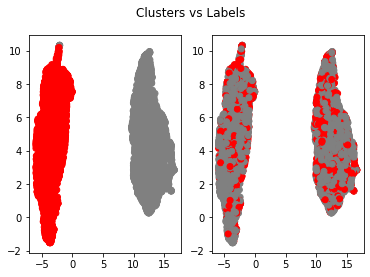

Epoch: 01 | NMI: 0.010 | ARI: 0.010 | Base_F1: 0.027 | Base_MCC: 0.069 | Base_AUC: 0.613 | CAC_F1: 0.042 | CAC_MCC: 0.099 | CAC_AUC: 0.500
converged at itr:  2
Class Dist:  tensor(0.1819)
Class Dist:  tensor(0.7497)
KM Dist:  tensor(7248.8574, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-971.0266)
Epoch: 01 | Batch: 001 | Loss: 6547.737 | Rec-Loss: 269.907 | Dist-Loss: 6277.831
Class Dist:  tensor(0.1908)
Class Dist:  tensor(0.8189)
KM Dist:  tensor(5564.6133, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1020.1199)
Epoch: 01 | Batch: 002 | Loss: 4826.939 | Rec-Loss: 282.446 | Dist-Loss: 4544.493
converged at itr:  2
Class Dist:  tensor(0.1966)
Class Dist:  tensor(0.8829)
KM Dist:  tensor(4403.7056, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1104.0244)
Epoch: 01 | Batch: 003 | Loss: 3595.294 | Rec-Loss: 295.613 | Dist-Loss: 3299.681
Class Dist:  tensor(0.2003)
Class Dist:  tensor(0.9319)
KM Dist:  tensor(3360.3889, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1118.4119)
Epoch: 01 | Batch: 004

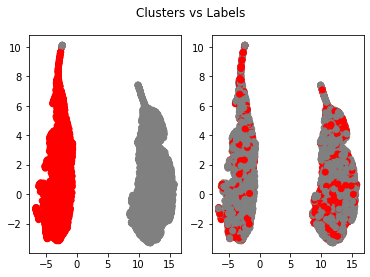

Epoch: 02 | NMI: 0.009 | ARI: 0.009 | Base_F1: 0.012 | Base_MCC: 0.049 | Base_AUC: 0.584 | CAC_F1: 0.016 | CAC_MCC: 0.075 | CAC_AUC: 0.497
Class Dist:  tensor(0.2069)
Class Dist:  tensor(0.9885)
KM Dist:  tensor(2054.9380, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1184.9900)
Epoch: 02 | Batch: 001 | Loss: 1179.748 | Rec-Loss: 309.800 | Dist-Loss: 869.948
Class Dist:  tensor(0.2166)
Class Dist:  tensor(0.9798)
KM Dist:  tensor(1886.3417, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1231.2482)
Epoch: 02 | Batch: 002 | Loss: 962.403 | Rec-Loss: 307.309 | Dist-Loss: 655.094
converged at itr:  2
Class Dist:  tensor(0.2194)
Class Dist:  tensor(0.9859)
KM Dist:  tensor(1605.9686, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1255.7389)
Epoch: 02 | Batch: 003 | Loss: 657.021 | Rec-Loss: 306.792 | Dist-Loss: 350.230
Class Dist:  tensor(0.2172)
Class Dist:  tensor(1.0040)
KM Dist:  tensor(1674.2023, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1201.7809)
Epoch: 02 | Batch: 004 | Loss: 775.420 | Rec-Lo

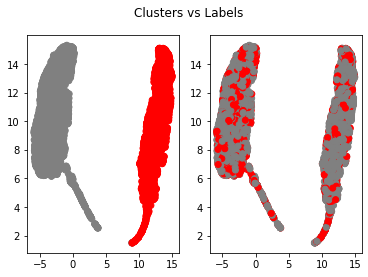

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 03 | NMI: 0.009 | ARI: 0.009 | Base_F1: 0.000 | Base_MCC: 0.000 | Base_AUC: 0.591 | CAC_F1: 0.000 | CAC_MCC: 0.000 | CAC_AUC: 0.512
converged at itr:  2
Class Dist:  tensor(0.2267)
Class Dist:  tensor(0.9803)
KM Dist:  tensor(1113.7733, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1270.6416)
Epoch: 03 | Batch: 001 | Loss: 126.583 | Rec-Loss: 283.452 | Dist-Loss: -156.868
converged at itr:  1
Class Dist:  tensor(0.2256)
Class Dist:  tensor(0.9901)
KM Dist:  tensor(704.1937, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1226.5249)
Epoch: 03 | Batch: 002 | Loss: -246.410 | Rec-Loss: 275.922 | Dist-Loss: -522.331
Class Dist:  tensor(0.2242)
Class Dist:  tensor(0.9849)
KM Dist:  tensor(787.4579, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1219.8417)
Epoch: 03 | Batch: 003 | Loss: -165.383 | Rec-Loss: 267.000 | Dist-Loss: -432.384
converged at itr:  1
Class Dist:  tensor(0.2261)
Class Dist:  tensor(0.9735)
KM Dist:  tensor(639.4448, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1249.3011)
Epoc

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


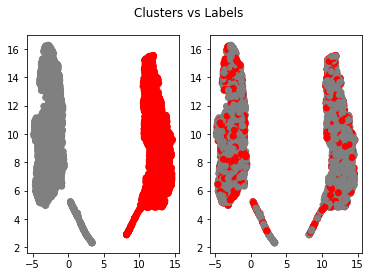

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 04 | NMI: 0.009 | ARI: 0.010 | Base_F1: 0.000 | Base_MCC: 0.000 | Base_AUC: 0.594 | CAC_F1: 0.000 | CAC_MCC: 0.000 | CAC_AUC: 0.499
converged at itr:  1
Class Dist:  tensor(0.2158)
Class Dist:  tensor(0.9672)
KM Dist:  tensor(500.0924, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1181.3485)
Epoch: 04 | Batch: 001 | Loss: -431.137 | Rec-Loss: 250.119 | Dist-Loss: -681.256
converged at itr:  1
Class Dist:  tensor(0.2145)
Class Dist:  tensor(0.9678)
KM Dist:  tensor(411.4026, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1186.5404)
Epoch: 04 | Batch: 002 | Loss: -535.210 | Rec-Loss: 239.928 | Dist-Loss: -775.138
converged at itr:  1
Class Dist:  tensor(0.2125)
Class Dist:  tensor(0.9580)
KM Dist:  tensor(343.7125, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1170.3025)
Epoch: 04 | Batch: 003 | Loss: -592.882 | Rec-Loss: 233.708 | Dist-Loss: -826.590
converged at itr:  1
Class Dist:  tensor(0.2110)
Class Dist:  tensor(0.9522)
KM Dist:  tensor(291.1281, grad_fn=<AddBackward0>)
Sep Dist:  te

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


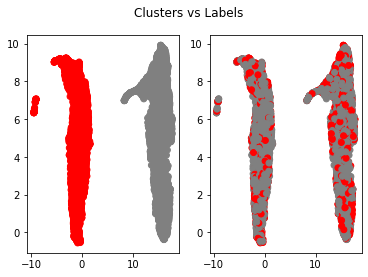

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 05 | NMI: 0.009 | ARI: 0.010 | Base_F1: 0.000 | Base_MCC: 0.000 | Base_AUC: 0.610 | CAC_F1: 0.000 | CAC_MCC: 0.000 | CAC_AUC: 0.500
converged at itr:  1
Class Dist:  tensor(0.2108)
Class Dist:  tensor(0.9231)
KM Dist:  tensor(184.7804, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1141.0807)
Epoch: 05 | Batch: 001 | Loss: -731.585 | Rec-Loss: 224.715 | Dist-Loss: -956.300
converged at itr:  1
Class Dist:  tensor(0.2082)
Class Dist:  tensor(0.9182)
KM Dist:  tensor(298.7463, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1123.5559)
Epoch: 05 | Batch: 002 | Loss: -600.647 | Rec-Loss: 224.162 | Dist-Loss: -824.810
converged at itr:  1
Class Dist:  tensor(0.2075)
Class Dist:  tensor(0.9028)
KM Dist:  tensor(391.3993, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1164.7882)
Epoch: 05 | Batch: 003 | Loss: -553.000 | Rec-Loss: 220.389 | Dist-Loss: -773.389
converged at itr:  1
Class Dist:  tensor(0.2053)
Class Dist:  tensor(0.8950)
KM Dist:  tensor(234.4438, grad_fn=<AddBackward0>)
Sep Dist:  te

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


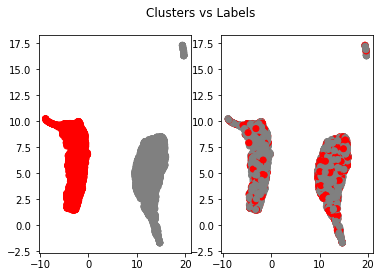

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 06 | NMI: 0.009 | ARI: 0.010 | Base_F1: 0.000 | Base_MCC: 0.000 | Base_AUC: 0.612 | CAC_F1: 0.004 | CAC_MCC: -0.024 | CAC_AUC: 0.499
converged at itr:  1
Class Dist:  tensor(0.2006)
Class Dist:  tensor(0.8842)
KM Dist:  tensor(182.1465, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1093.0632)
Epoch: 06 | Batch: 001 | Loss: -695.777 | Rec-Loss: 215.139 | Dist-Loss: -910.917
converged at itr:  1
Class Dist:  tensor(0.1998)
Class Dist:  tensor(0.8771)
KM Dist:  tensor(125.9389, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1087.9133)
Epoch: 06 | Batch: 002 | Loss: -747.587 | Rec-Loss: 214.388 | Dist-Loss: -961.974
converged at itr:  1
Class Dist:  tensor(0.1968)
Class Dist:  tensor(0.8703)
KM Dist:  tensor(138.2923, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1073.8652)
Epoch: 06 | Batch: 003 | Loss: -725.108 | Rec-Loss: 210.465 | Dist-Loss: -935.573
converged at itr:  1
Class Dist:  tensor(0.1962)
Class Dist:  tensor(0.8605)
KM Dist:  tensor(156.9457, grad_fn=<AddBackward0>)
Sep Dist:  t

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


CAC Training F1: 0.0
CAC Training MCC: -0.011252183261560664
CAC Training AUC: 0.5758660536895587
Final CAC Training F1: 0.0
Final CAC Training MCC: -0.008783455617399905
Final CAC Training AUC: 0.5871949489069126


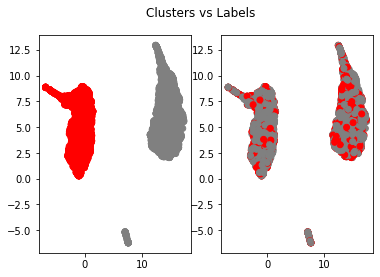

Epoch: 07 | NMI: 0.009 | ARI: 0.009 | Base_F1: 0.004 | Base_MCC: 0.038 | Base_AUC: 0.610 | CAC_F1: 0.012 | CAC_MCC: 0.008 | CAC_AUC: 0.507
converged at itr:  1
Class Dist:  tensor(0.1925)
Class Dist:  tensor(0.8463)
KM Dist:  tensor(102.4530, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1049.3163)
Epoch: 07 | Batch: 001 | Loss: -740.624 | Rec-Loss: 206.240 | Dist-Loss: -946.863
converged at itr:  1
Class Dist:  tensor(0.1927)
Class Dist:  tensor(0.8346)
KM Dist:  tensor(198.6308, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1075.0438)
Epoch: 07 | Batch: 002 | Loss: -668.520 | Rec-Loss: 207.893 | Dist-Loss: -876.413
converged at itr:  1
Class Dist:  tensor(0.1901)
Class Dist:  tensor(0.8308)
KM Dist:  tensor(153.3422, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1016.0162)
Epoch: 07 | Batch: 003 | Loss: -655.447 | Rec-Loss: 207.227 | Dist-Loss: -862.674
converged at itr:  1
Class Dist:  tensor(0.1884)
Class Dist:  tensor(0.8213)
KM Dist:  tensor(83.3881, grad_fn=<AddBackward0>)
Sep Dist:  ten

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


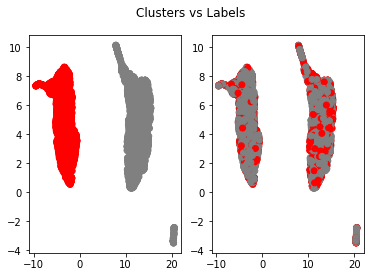

Epoch: 08 | NMI: 0.009 | ARI: 0.009 | Base_F1: 0.023 | Base_MCC: 0.069 | Base_AUC: 0.604 | CAC_F1: 0.016 | CAC_MCC: 0.019 | CAC_AUC: 0.513
converged at itr:  1
Class Dist:  tensor(0.1849)
Class Dist:  tensor(0.8074)
KM Dist:  tensor(84.8948, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1007.4756)
Epoch: 08 | Batch: 001 | Loss: -719.024 | Rec-Loss: 203.556 | Dist-Loss: -922.581
converged at itr:  1
Class Dist:  tensor(0.1831)
Class Dist:  tensor(0.8032)
KM Dist:  tensor(73.3283, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-993.8333)
Epoch: 08 | Batch: 002 | Loss: -718.499 | Rec-Loss: 202.006 | Dist-Loss: -920.505
converged at itr:  1
Class Dist:  tensor(0.1807)
Class Dist:  tensor(0.7985)
KM Dist:  tensor(95.6776, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-978.0301)
Epoch: 08 | Batch: 003 | Loss: -682.933 | Rec-Loss: 199.420 | Dist-Loss: -882.353
converged at itr:  1
Class Dist:  tensor(0.1793)
Class Dist:  tensor(0.7917)
KM Dist:  tensor(67.8990, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


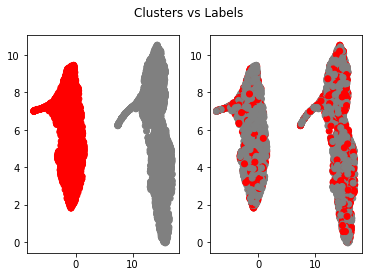

Epoch: 09 | NMI: 0.009 | ARI: 0.009 | Base_F1: 0.038 | Base_MCC: 0.061 | Base_AUC: 0.600 | CAC_F1: 0.038 | CAC_MCC: 0.061 | CAC_AUC: 0.512
converged at itr:  1
Class Dist:  tensor(0.1773)
Class Dist:  tensor(0.7760)
KM Dist:  tensor(81.3273, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-982.1879)
Epoch: 09 | Batch: 001 | Loss: -699.145 | Rec-Loss: 201.716 | Dist-Loss: -900.861
converged at itr:  1
Class Dist:  tensor(0.1759)
Class Dist:  tensor(0.7709)
KM Dist:  tensor(63.7762, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-958.7961)
Epoch: 09 | Batch: 002 | Loss: -695.049 | Rec-Loss: 199.971 | Dist-Loss: -895.020
converged at itr:  1
Class Dist:  tensor(0.1749)
Class Dist:  tensor(0.7629)
KM Dist:  tensor(66.1056, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-967.4000)
Epoch: 09 | Batch: 003 | Loss: -700.757 | Rec-Loss: 200.537 | Dist-Loss: -901.294
converged at itr:  1
Class Dist:  tensor(0.1730)
Class Dist:  tensor(0.7588)
KM Dist:  tensor(81.0212, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-9

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


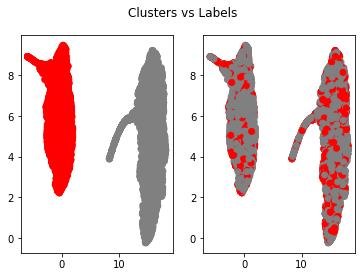

Epoch: 10 | NMI: 0.009 | ARI: 0.009 | Base_F1: 0.038 | Base_MCC: 0.051 | Base_AUC: 0.601 | CAC_F1: 0.038 | CAC_MCC: 0.051 | CAC_AUC: 0.511
converged at itr:  1
Class Dist:  tensor(0.1701)
Class Dist:  tensor(0.7491)
KM Dist:  tensor(49.5529, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-943.6010)
Epoch: 10 | Batch: 001 | Loss: -696.788 | Rec-Loss: 197.260 | Dist-Loss: -894.048
converged at itr:  1
Class Dist:  tensor(0.1690)
Class Dist:  tensor(0.7446)
KM Dist:  tensor(41.5165, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-926.2974)
Epoch: 10 | Batch: 002 | Loss: -684.876 | Rec-Loss: 199.905 | Dist-Loss: -884.781
converged at itr:  1
Class Dist:  tensor(0.1675)
Class Dist:  tensor(0.7393)
KM Dist:  tensor(54.6170, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-912.5458)
Epoch: 10 | Batch: 003 | Loss: -659.011 | Rec-Loss: 198.918 | Dist-Loss: -857.929
converged at itr:  1
Class Dist:  tensor(0.1659)
Class Dist:  tensor(0.7352)
KM Dist:  tensor(57.3133, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-9

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


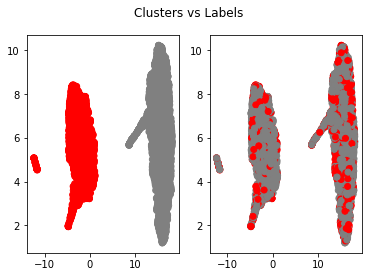

Epoch: 11 | NMI: 0.009 | ARI: 0.010 | Base_F1: 0.035 | Base_MCC: 0.053 | Base_AUC: 0.599 | CAC_F1: 0.038 | CAC_MCC: 0.051 | CAC_AUC: 0.498
converged at itr:  1
Class Dist:  tensor(0.1633)
Class Dist:  tensor(0.7232)
KM Dist:  tensor(37.1537, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-896.5884)
Epoch: 11 | Batch: 001 | Loss: -664.820 | Rec-Loss: 194.615 | Dist-Loss: -859.435
converged at itr:  1
Class Dist:  tensor(0.1620)
Class Dist:  tensor(0.7182)
KM Dist:  tensor(31.5708, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-899.1178)
Epoch: 11 | Batch: 002 | Loss: -672.056 | Rec-Loss: 195.491 | Dist-Loss: -867.547
converged at itr:  1
Class Dist:  tensor(0.1610)
Class Dist:  tensor(0.7137)
KM Dist:  tensor(33.1758, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-891.2415)
Epoch: 11 | Batch: 003 | Loss: -659.627 | Rec-Loss: 198.439 | Dist-Loss: -858.066
converged at itr:  1
Class Dist:  tensor(0.1600)
Class Dist:  tensor(0.7081)
KM Dist:  tensor(31.2144, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-8

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


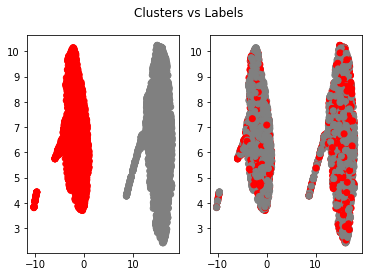

Epoch: 12 | NMI: 0.009 | ARI: 0.009 | Base_F1: 0.038 | Base_MCC: 0.051 | Base_AUC: 0.598 | CAC_F1: 0.038 | CAC_MCC: 0.061 | CAC_AUC: 0.513
converged at itr:  1
Class Dist:  tensor(0.1575)
Class Dist:  tensor(0.7013)
KM Dist:  tensor(73.8937, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-858.6553)
Epoch: 12 | Batch: 001 | Loss: -590.392 | Rec-Loss: 194.370 | Dist-Loss: -784.762
converged at itr:  1
Class Dist:  tensor(0.1566)
Class Dist:  tensor(0.6966)
KM Dist:  tensor(50.0742, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-878.0541)
Epoch: 12 | Batch: 002 | Loss: -631.858 | Rec-Loss: 196.122 | Dist-Loss: -827.980
converged at itr:  1
Class Dist:  tensor(0.1550)
Class Dist:  tensor(0.6935)
KM Dist:  tensor(99.0336, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-840.8268)
Epoch: 12 | Batch: 003 | Loss: -548.909 | Rec-Loss: 192.884 | Dist-Loss: -741.793
converged at itr:  1
Class Dist:  tensor(0.1544)
Class Dist:  tensor(0.6877)
KM Dist:  tensor(73.3093, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-8

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


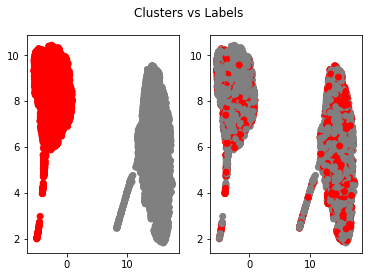

Epoch: 13 | NMI: 0.009 | ARI: 0.010 | Base_F1: 0.038 | Base_MCC: 0.046 | Base_AUC: 0.597 | CAC_F1: 0.038 | CAC_MCC: 0.056 | CAC_AUC: 0.497
converged at itr:  1
Class Dist:  tensor(0.1518)
Class Dist:  tensor(0.6798)
KM Dist:  tensor(220.6344, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-813.6246)
Epoch: 13 | Batch: 001 | Loss: -395.484 | Rec-Loss: 197.506 | Dist-Loss: -592.990
converged at itr:  1
Class Dist:  tensor(0.1505)
Class Dist:  tensor(0.6773)
KM Dist:  tensor(69.5588, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-824.4873)
Epoch: 13 | Batch: 002 | Loss: -562.157 | Rec-Loss: 192.771 | Dist-Loss: -754.929
converged at itr:  1
Class Dist:  tensor(0.1496)
Class Dist:  tensor(0.6723)
KM Dist:  tensor(48.6742, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-845.8394)
Epoch: 13 | Batch: 003 | Loss: -605.369 | Rec-Loss: 191.796 | Dist-Loss: -797.165
converged at itr:  1
Class Dist:  tensor(0.1502)
Class Dist:  tensor(0.6650)
KM Dist:  tensor(347.4454, grad_fn=<AddBackward0>)
Sep Dist:  tensor(

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


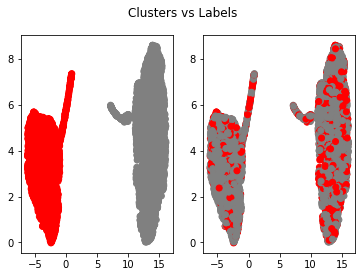

Epoch: 14 | NMI: 0.009 | ARI: 0.009 | Base_F1: 0.038 | Base_MCC: 0.061 | Base_AUC: 0.597 | CAC_F1: 0.016 | CAC_MCC: 0.014 | CAC_AUC: 0.505
converged at itr:  1
Class Dist:  tensor(0.1482)
Class Dist:  tensor(0.6556)
KM Dist:  tensor(89.5996, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-836.2854)
Epoch: 14 | Batch: 001 | Loss: -554.590 | Rec-Loss: 192.096 | Dist-Loss: -746.686
converged at itr:  1
Class Dist:  tensor(0.1475)
Class Dist:  tensor(0.6515)
KM Dist:  tensor(28.6365, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-816.1519)
Epoch: 14 | Batch: 002 | Loss: -594.814 | Rec-Loss: 192.701 | Dist-Loss: -787.515
converged at itr:  1
Class Dist:  tensor(0.1469)
Class Dist:  tensor(0.6483)
KM Dist:  tensor(21.4157, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-812.2686)
Epoch: 14 | Batch: 003 | Loss: -599.111 | Rec-Loss: 191.741 | Dist-Loss: -790.853
converged at itr:  1
Class Dist:  tensor(0.1456)
Class Dist:  tensor(0.6461)
KM Dist:  tensor(91.5783, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-7

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


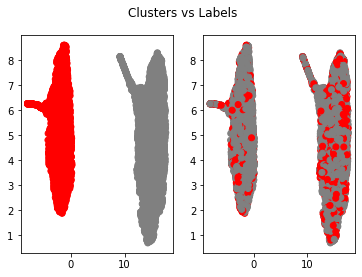

Epoch: 15 | NMI: 0.009 | ARI: 0.009 | Base_F1: 0.035 | Base_MCC: 0.071 | Base_AUC: 0.598 | CAC_F1: 0.016 | CAC_MCC: 0.009 | CAC_AUC: 0.506
converged at itr:  1
Class Dist:  tensor(0.1435)
Class Dist:  tensor(0.6390)
KM Dist:  tensor(24.6489, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-801.3303)
Epoch: 15 | Batch: 001 | Loss: -586.681 | Rec-Loss: 190.000 | Dist-Loss: -776.681
converged at itr:  1
Class Dist:  tensor(0.1423)
Class Dist:  tensor(0.6367)
KM Dist:  tensor(103.7334, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-771.9644)
Epoch: 15 | Batch: 002 | Loss: -478.089 | Rec-Loss: 190.142 | Dist-Loss: -668.231
converged at itr:  1
Class Dist:  tensor(0.1420)
Class Dist:  tensor(0.6333)
KM Dist:  tensor(36.1128, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-798.8120)
Epoch: 15 | Batch: 003 | Loss: -571.261 | Rec-Loss: 191.438 | Dist-Loss: -762.699
converged at itr:  1
Class Dist:  tensor(0.1411)
Class Dist:  tensor(0.6304)
KM Dist:  tensor(25.2369, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


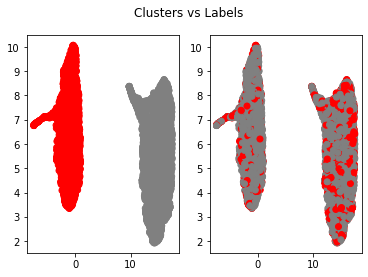

Epoch: 16 | NMI: 0.010 | ARI: 0.010 | Base_F1: 0.038 | Base_MCC: 0.051 | Base_AUC: 0.595 | CAC_F1: 0.019 | CAC_MCC: 0.019 | CAC_AUC: 0.492
converged at itr:  1
Class Dist:  tensor(0.1391)
Class Dist:  tensor(0.6223)
KM Dist:  tensor(16.0166, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-774.8769)
Epoch: 16 | Batch: 001 | Loss: -569.568 | Rec-Loss: 189.293 | Dist-Loss: -758.860
converged at itr:  1
Class Dist:  tensor(0.1391)
Class Dist:  tensor(0.6169)
KM Dist:  tensor(226.4795, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-800.9568)
Epoch: 16 | Batch: 002 | Loss: -379.598 | Rec-Loss: 194.879 | Dist-Loss: -574.477
converged at itr:  1
Class Dist:  tensor(0.1382)
Class Dist:  tensor(0.6148)
KM Dist:  tensor(38.2874, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-757.7471)
Epoch: 16 | Batch: 003 | Loss: -529.352 | Rec-Loss: 190.108 | Dist-Loss: -719.460
converged at itr:  1
Class Dist:  tensor(0.1372)
Class Dist:  tensor(0.6125)
KM Dist:  tensor(41.8467, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


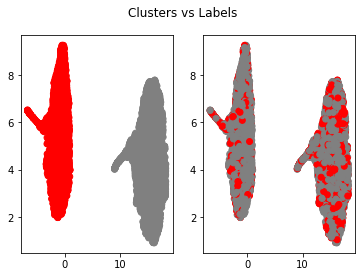

Epoch: 17 | NMI: 0.009 | ARI: 0.009 | Base_F1: 0.038 | Base_MCC: 0.061 | Base_AUC: 0.598 | CAC_F1: 0.019 | CAC_MCC: 0.019 | CAC_AUC: 0.503
converged at itr:  1
Class Dist:  tensor(0.1348)
Class Dist:  tensor(0.6090)
KM Dist:  tensor(149.7410, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-732.1796)
Epoch: 17 | Batch: 001 | Loss: -392.388 | Rec-Loss: 190.051 | Dist-Loss: -582.439
converged at itr:  1
Class Dist:  tensor(0.1340)
Class Dist:  tensor(0.6065)
KM Dist:  tensor(16.6654, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-753.5667)
Epoch: 17 | Batch: 002 | Loss: -548.217 | Rec-Loss: 188.684 | Dist-Loss: -736.901
converged at itr:  1
Class Dist:  tensor(0.1330)
Class Dist:  tensor(0.6047)
KM Dist:  tensor(28.9391, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-742.1879)
Epoch: 17 | Batch: 003 | Loss: -526.303 | Rec-Loss: 186.946 | Dist-Loss: -713.249
converged at itr:  1
Class Dist:  tensor(0.1328)
Class Dist:  tensor(0.6006)
KM Dist:  tensor(55.2940, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


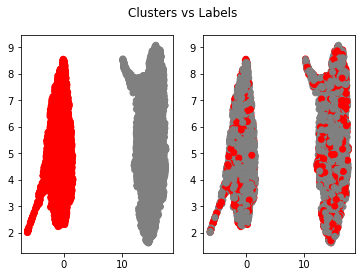

Epoch: 18 | NMI: 0.010 | ARI: 0.010 | Base_F1: 0.035 | Base_MCC: 0.078 | Base_AUC: 0.596 | CAC_F1: 0.012 | CAC_MCC: -0.002 | CAC_AUC: 0.492
converged at itr:  1
Class Dist:  tensor(0.1321)
Class Dist:  tensor(0.5921)
KM Dist:  tensor(79.3618, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-753.5796)
Epoch: 18 | Batch: 001 | Loss: -486.912 | Rec-Loss: 187.306 | Dist-Loss: -674.218
converged at itr:  1
Class Dist:  tensor(0.1317)
Class Dist:  tensor(0.5891)
KM Dist:  tensor(29.4731, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-741.7537)
Epoch: 18 | Batch: 002 | Loss: -525.169 | Rec-Loss: 187.112 | Dist-Loss: -712.281
converged at itr:  1
Class Dist:  tensor(0.1309)
Class Dist:  tensor(0.5869)
KM Dist:  tensor(36.0189, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-720.4319)
Epoch: 18 | Batch: 003 | Loss: -497.877 | Rec-Loss: 186.536 | Dist-Loss: -684.413
converged at itr:  1
Class Dist:  tensor(0.1305)
Class Dist:  tensor(0.5840)
KM Dist:  tensor(19.3019, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


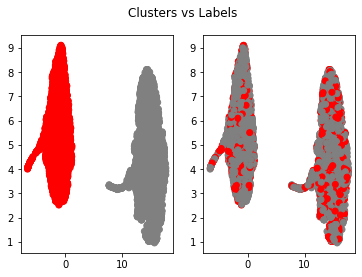

Epoch: 19 | NMI: 0.009 | ARI: 0.009 | Base_F1: 0.016 | Base_MCC: 0.049 | Base_AUC: 0.596 | CAC_F1: 0.023 | CAC_MCC: 0.039 | CAC_AUC: 0.500
converged at itr:  1
Class Dist:  tensor(0.1282)
Class Dist:  tensor(0.5816)
KM Dist:  tensor(113.6963, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-701.3712)
Epoch: 19 | Batch: 001 | Loss: -400.111 | Rec-Loss: 187.564 | Dist-Loss: -587.675
converged at itr:  1
Class Dist:  tensor(0.1276)
Class Dist:  tensor(0.5782)
KM Dist:  tensor(68.0222, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-733.5543)
Epoch: 19 | Batch: 002 | Loss: -477.052 | Rec-Loss: 188.480 | Dist-Loss: -665.532
converged at itr:  1
Class Dist:  tensor(0.1273)
Class Dist:  tensor(0.5746)
KM Dist:  tensor(72.3115, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-730.3690)
Epoch: 19 | Batch: 003 | Loss: -473.226 | Rec-Loss: 184.832 | Dist-Loss: -658.057
converged at itr:  1
Class Dist:  tensor(0.1266)
Class Dist:  tensor(0.5726)
KM Dist:  tensor(33.8799, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


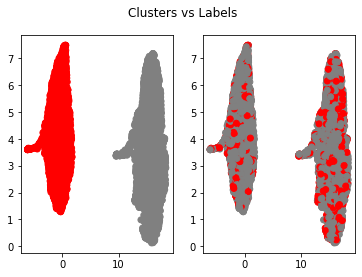

Epoch: 20 | NMI: 0.009 | ARI: 0.009 | Base_F1: 0.035 | Base_MCC: 0.059 | Base_AUC: 0.596 | CAC_F1: 0.019 | CAC_MCC: 0.024 | CAC_AUC: 0.505


In [87]:
# k-Means DCN
reducer = umap.UMAP()
for e in range(args.epoch):
    model.train()
    model.fit(e, train_loader)
    model.eval()
    out = model.autoencoder(torch.FloatTensor(np.array(X_train)).to(args.device), latent=True)
    cluster_id = model.clustering.update_assign(out.cpu().detach().numpy())
    X2 = reducer.fit_transform(out.cpu().detach().numpy())
    c_clusters = [color[int(cluster_id[i])] for i in range(len(cluster_id))]
    c_labels = [color[int(y_train[i])] for i in range(len(cluster_id))]

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Clusters vs Labels')
    ax1.scatter(X2[:,0], X2[:,1], color=c_clusters)
    ax2.scatter(X2[:,0], X2[:,1], color=c_labels)
    plt.show()

    out = evaluate(model, test_loader)  # evaluation on the test_loader
    if len(out) > 2:
        NMI, ARI, base_f1, base_mcc, base_auc, cac_f1, cac_mcc, cac_auc = out
        print('Epoch: {:02d} | NMI: {:.3f} | ARI: {:.3f} | Base_F1: {:.3f} | Base_MCC: {:.3f} | Base_AUC: {:.3f} | CAC_F1: {:.3f} | CAC_MCC: {:.3f} | CAC_AUC: {:.3f}'.format(
            e+1, NMI, ARI, base_f1, base_mcc, base_auc, cac_f1, cac_mcc, cac_auc))
    else:
        NMI, ARI = out
        print('Epoch: {:02d} | NMI: {:.3f} | ARI: {:.3f}'.format(e+1, NMI, ARI))

    nmi_list.append(NMI)
    ari_list.append(ARI)

[100. 100.]


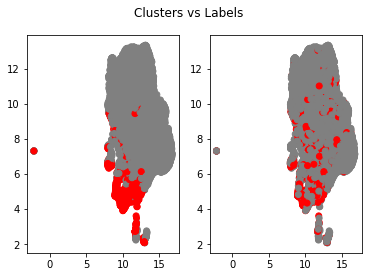

<Figure size 432x288 with 0 Axes>

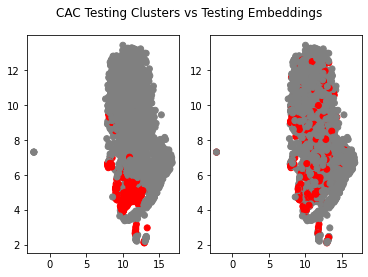

converged at itr:  5
Class Dist:  tensor(1.7024)
Class Dist:  tensor(28.1765)
KM Dist:  tensor(80243.1250, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-100796.5391)
Epoch: 00 | Batch: 001 | Loss: -20354.750 | Rec-Loss: 198.666 | Dist-Loss: -20553.414
converged at itr:  3
Class Dist:  tensor(2.1146)
Class Dist:  tensor(35.7716)
KM Dist:  tensor(68991.6484, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-128076.1875)
Epoch: 00 | Batch: 002 | Loss: -58874.609 | Rec-Loss: 209.932 | Dist-Loss: -59084.539
converged at itr:  3
Class Dist:  tensor(2.5276)
Class Dist:  tensor(44.7212)
KM Dist:  tensor(65064.6172, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-161068.3438)
Epoch: 00 | Batch: 003 | Loss: -95787.891 | Rec-Loss: 215.834 | Dist-Loss: -96003.727
converged at itr:  3
Class Dist:  tensor(2.9084)
Class Dist:  tensor(63.9068)
KM Dist:  tensor(62752.8281, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-231262.2031)
Epoch: 00 | Batch: 004 | Loss: -168277.016 | Rec-Loss: 232.363 | Dist-Loss: -168509.375
co

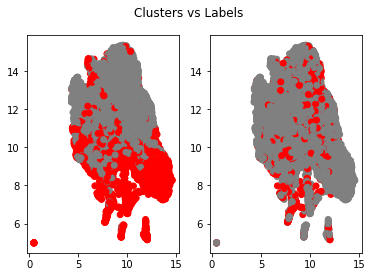

<Figure size 432x288 with 0 Axes>

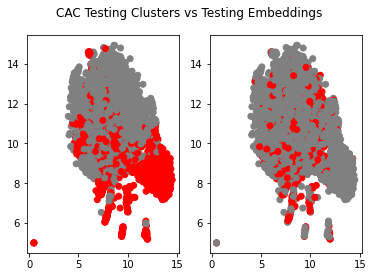

converged at itr:  2
Class Dist:  tensor(3.5152)
Class Dist:  tensor(770572.4375)
KM Dist:  tensor(52285.8438, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-2.8172e+09)
Epoch: 01 | Batch: 001 | Loss: -2817135616.000 | Rec-Loss: 374.952 | Dist-Loss: -2817136128.000
converged at itr:  2
Class Dist:  tensor(6.8035)
Class Dist:  tensor(749435.2500)
KM Dist:  tensor(51583.6797, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-2.7849e+09)
Epoch: 01 | Batch: 002 | Loss: -2784862976.000 | Rec-Loss: 398.358 | Dist-Loss: -2784863488.000
converged at itr:  2
Class Dist:  tensor(698956.8125)
Class Dist:  tensor(732739.1250)
KM Dist:  tensor(49975.1445, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-2.9693e+09)
Epoch: 01 | Batch: 003 | Loss: -2969204992.000 | Rec-Loss: 430.381 | Dist-Loss: -2969205504.000
converged at itr:  1
Class Dist:  tensor(625168.9375)
Class Dist:  tensor(722618.1875)
KM Dist:  tensor(46418.1172, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-2.7295e+09)
Epoch: 01 | Batch: 004 | Loss: -272943

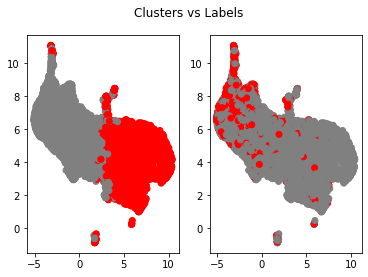

<Figure size 432x288 with 0 Axes>

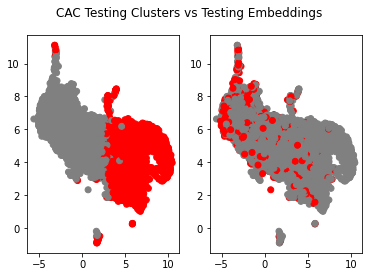

converged at itr:  1
Class Dist:  tensor(373619.4688)
Class Dist:  tensor(684182.2500)
KM Dist:  tensor(35720.8789, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-2.0620e+09)
Epoch: 02 | Batch: 001 | Loss: -2062009856.000 | Rec-Loss: 566.373 | Dist-Loss: -2062010368.000
converged at itr:  1
Class Dist:  tensor(346924.0625)
Class Dist:  tensor(677226.3750)
KM Dist:  tensor(33510.1875, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.9825e+09)
Epoch: 02 | Batch: 002 | Loss: -1982465280.000 | Rec-Loss: 597.032 | Dist-Loss: -1982465792.000
converged at itr:  1
Class Dist:  tensor(321631.8750)
Class Dist:  tensor(675264.)
KM Dist:  tensor(31513.5039, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.8875e+09)
Epoch: 02 | Batch: 003 | Loss: -1887427328.000 | Rec-Loss: 625.637 | Dist-Loss: -1887427968.000
converged at itr:  1
Class Dist:  tensor(300445.3750)
Class Dist:  tensor(671859.5625)
KM Dist:  tensor(29760.0312, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.8323e+09)
Epoch: 02 | Batch: 004 | Loss: -

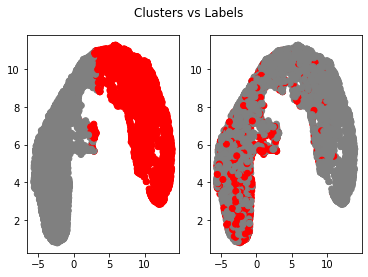

<Figure size 432x288 with 0 Axes>

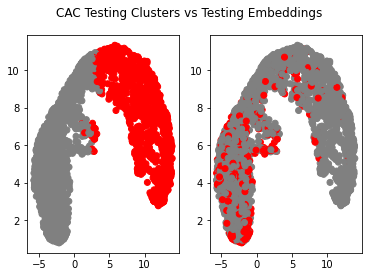

converged at itr:  1
Class Dist:  tensor(209987.8125)
Class Dist:  tensor(659359.9375)
KM Dist:  tensor(20233.4199, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.5971e+09)
Epoch: 03 | Batch: 001 | Loss: -1597052032.000 | Rec-Loss: 758.706 | Dist-Loss: -1597052800.000
converged at itr:  1
Class Dist:  tensor(198819.5156)
Class Dist:  tensor(657124.6250)
KM Dist:  tensor(18664.2715, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.5366e+09)
Epoch: 03 | Batch: 002 | Loss: -1536623360.000 | Rec-Loss: 752.776 | Dist-Loss: -1536624128.000
converged at itr:  1
Class Dist:  tensor(188825.8906)
Class Dist:  tensor(654990.7500)
KM Dist:  tensor(17176.5977, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.5454e+09)
Epoch: 03 | Batch: 003 | Loss: -1545382784.000 | Rec-Loss: 746.499 | Dist-Loss: -1545383552.000
converged at itr:  1
Class Dist:  tensor(179885.5312)
Class Dist:  tensor(652708.3750)
KM Dist:  tensor(16230.1367, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.5330e+09)
Epoch: 03 | Batch: 004 | Los

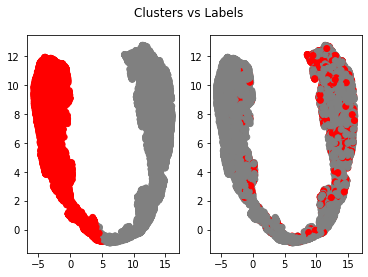

<Figure size 432x288 with 0 Axes>

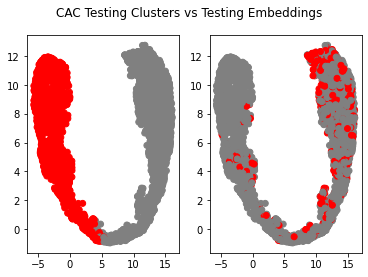

converged at itr:  1
Class Dist:  tensor(140378.2500)
Class Dist:  tensor(642233.6250)
KM Dist:  tensor(10598.0762, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.4522e+09)
Epoch: 04 | Batch: 001 | Loss: -1452235392.000 | Rec-Loss: 762.046 | Dist-Loss: -1452236160.000
converged at itr:  1
Class Dist:  tensor(135005.2500)
Class Dist:  tensor(640737.8125)
KM Dist:  tensor(9996.0068, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.4532e+09)
Epoch: 04 | Batch: 002 | Loss: -1453176448.000 | Rec-Loss: 735.958 | Dist-Loss: -1453177216.000
converged at itr:  1
Class Dist:  tensor(130119.5547)
Class Dist:  tensor(639206.)
KM Dist:  tensor(9003.5928, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.4412e+09)
Epoch: 04 | Batch: 003 | Loss: -1441153536.000 | Rec-Loss: 768.924 | Dist-Loss: -1441154304.000
converged at itr:  1
Class Dist:  tensor(125469.9219)
Class Dist:  tensor(637722.8125)
KM Dist:  tensor(8834.9883, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.4237e+09)
Epoch: 04 | Batch: 004 | Loss: -142

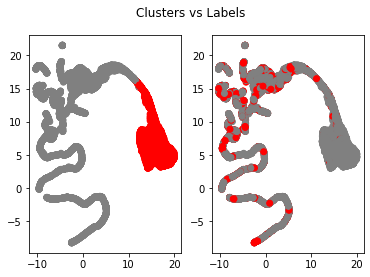

<Figure size 432x288 with 0 Axes>

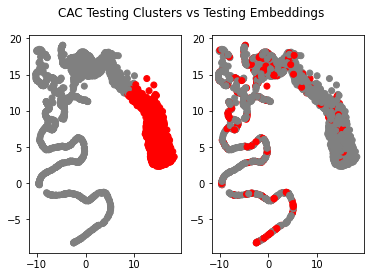

converged at itr:  1
Class Dist:  tensor(102943.7969)
Class Dist:  tensor(629034.3125)
KM Dist:  tensor(6045.2627, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.3897e+09)
Epoch: 05 | Batch: 001 | Loss: -1389657216.000 | Rec-Loss: 684.902 | Dist-Loss: -1389657984.000
converged at itr:  1
Class Dist:  tensor(99760.3203)
Class Dist:  tensor(627485.5000)
KM Dist:  tensor(5837.6616, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.3395e+09)
Epoch: 05 | Batch: 002 | Loss: -1339528832.000 | Rec-Loss: 702.654 | Dist-Loss: -1339529472.000
converged at itr:  1
Class Dist:  tensor(96701.0703)
Class Dist:  tensor(626376.8125)
KM Dist:  tensor(5344.5869, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.3453e+09)
Epoch: 05 | Batch: 003 | Loss: -1345267072.000 | Rec-Loss: 675.368 | Dist-Loss: -1345267712.000
converged at itr:  1
Class Dist:  tensor(93925.5547)
Class Dist:  tensor(625102.8125)
KM Dist:  tensor(5132.5205, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.3408e+09)
Epoch: 05 | Batch: 004 | Loss: -134

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(0.05977841643334149, -0.004094040133701687, 0.0, -0.0074490033485172195, 0.736942413627709, 0.0, -0.0074490033485172195, 0.4809305097309633)
Epoch: 06 | NMI: 0.060 | ARI: -0.004 | Base_F1: 0.000 | Base_MCC: -0.007 | Base_AUC: 0.737 | CAC_F1: 0.000 | CAC_MCC: -0.007 | CAC_AUC: 0.481


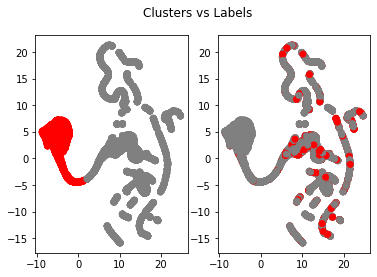

<Figure size 432x288 with 0 Axes>

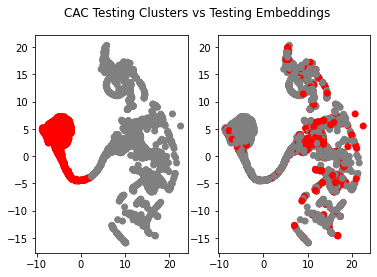

converged at itr:  1
Class Dist:  tensor(79541.6250)
Class Dist:  tensor(618051.2500)
KM Dist:  tensor(3653.9111, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.2650e+09)
Epoch: 06 | Batch: 001 | Loss: -1264954240.000 | Rec-Loss: 629.413 | Dist-Loss: -1264954752.000
converged at itr:  1
Class Dist:  tensor(77476.7734)
Class Dist:  tensor(617138.2500)
KM Dist:  tensor(3401.1477, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.2995e+09)
Epoch: 06 | Batch: 002 | Loss: -1299521152.000 | Rec-Loss: 632.877 | Dist-Loss: -1299521792.000
converged at itr:  1
Class Dist:  tensor(75520.7188)
Class Dist:  tensor(615809.4375)
KM Dist:  tensor(3396.1406, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.2862e+09)
Epoch: 06 | Batch: 003 | Loss: -1286167168.000 | Rec-Loss: 589.363 | Dist-Loss: -1286167680.000
converged at itr:  1
Class Dist:  tensor(73560.1562)
Class Dist:  tensor(615042.)
KM Dist:  tensor(3221.8706, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.2803e+09)
Epoch: 06 | Batch: 004 | Loss: -12803054

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(0.060008622572981, -0.0037154593172568236, 0.0, 0.0, 0.7320183391229779, 0.0, 0.0, 0.4751529774276536)
Epoch: 07 | NMI: 0.060 | ARI: -0.004 | Base_F1: 0.000 | Base_MCC: 0.000 | Base_AUC: 0.732 | CAC_F1: 0.000 | CAC_MCC: 0.000 | CAC_AUC: 0.475


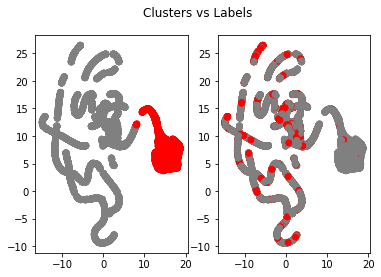

<Figure size 432x288 with 0 Axes>

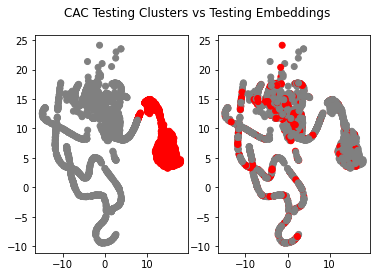

converged at itr:  1
Class Dist:  tensor(63612.5117)
Class Dist:  tensor(610429.1250)
KM Dist:  tensor(2392.1028, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.1814e+09)
Epoch: 07 | Batch: 001 | Loss: -1181403008.000 | Rec-Loss: 577.778 | Dist-Loss: -1181403520.000
converged at itr:  1
Class Dist:  tensor(62186.5312)
Class Dist:  tensor(609288.6875)
KM Dist:  tensor(2316.3000, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.2351e+09)
Epoch: 07 | Batch: 002 | Loss: -1235124096.000 | Rec-Loss: 581.182 | Dist-Loss: -1235124736.000
converged at itr:  1
Class Dist:  tensor(60784.7578)
Class Dist:  tensor(608674.7500)
KM Dist:  tensor(2191.3997, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.2461e+09)
Epoch: 07 | Batch: 003 | Loss: -1246131328.000 | Rec-Loss: 582.743 | Dist-Loss: -1246131968.000
converged at itr:  1
Class Dist:  tensor(59461.3320)
Class Dist:  tensor(607802.5000)
KM Dist:  tensor(2121.7305, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.2086e+09)
Epoch: 07 | Batch: 004 | Loss: -1208

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(0.06384758986995162, -0.002127150990255742, 0.004662004662004662, 0.04476363694482778, 0.7094264618246828, 0.0, 0.0, 0.47869943750817573)
Epoch: 08 | NMI: 0.064 | ARI: -0.002 | Base_F1: 0.005 | Base_MCC: 0.045 | Base_AUC: 0.709 | CAC_F1: 0.000 | CAC_MCC: 0.000 | CAC_AUC: 0.479


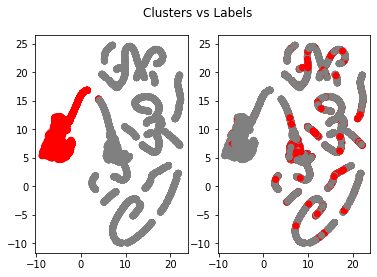

<Figure size 432x288 with 0 Axes>

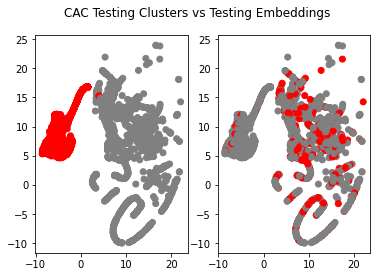

converged at itr:  1
Class Dist:  tensor(52542.1016)
Class Dist:  tensor(603182.7500)
KM Dist:  tensor(1602.8755, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.2240e+09)
Epoch: 08 | Batch: 001 | Loss: -1223986304.000 | Rec-Loss: 548.653 | Dist-Loss: -1223986816.000
converged at itr:  1
Class Dist:  tensor(51447.1914)
Class Dist:  tensor(602406.9375)
KM Dist:  tensor(1710.7012, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.1672e+09)
Epoch: 08 | Batch: 002 | Loss: -1167180544.000 | Rec-Loss: 557.259 | Dist-Loss: -1167181184.000
converged at itr:  1
Class Dist:  tensor(50450.2383)
Class Dist:  tensor(601567.1250)
KM Dist:  tensor(1387.2048, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.2273e+09)
Epoch: 08 | Batch: 003 | Loss: -1227313920.000 | Rec-Loss: 549.158 | Dist-Loss: -1227314432.000
converged at itr:  1
Class Dist:  tensor(49429.9375)
Class Dist:  tensor(600933.5625)
KM Dist:  tensor(1405.5544, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.1908e+09)
Epoch: 08 | Batch: 004 | Loss: -1190

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(0.05935132131285203, -0.006343142836972109, 0.004662004662004662, 0.04476363694482778, 0.7281988997252948, 0.0, 0.0, 0.4847022572346332)
Epoch: 09 | NMI: 0.059 | ARI: -0.006 | Base_F1: 0.005 | Base_MCC: 0.045 | Base_AUC: 0.728 | CAC_F1: 0.000 | CAC_MCC: 0.000 | CAC_AUC: 0.485


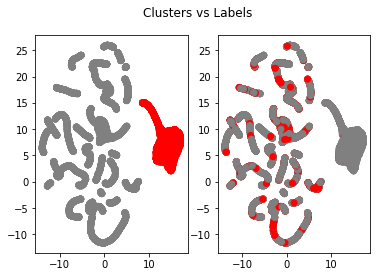

<Figure size 432x288 with 0 Axes>

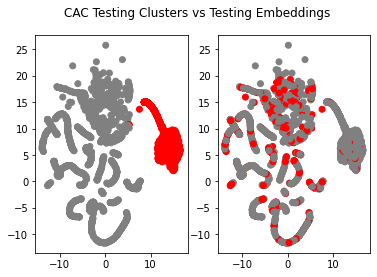

converged at itr:  1
Class Dist:  tensor(44153.8789)
Class Dist:  tensor(597468.6250)
KM Dist:  tensor(1194.0973, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.1193e+09)
Epoch: 09 | Batch: 001 | Loss: -1119284608.000 | Rec-Loss: 575.336 | Dist-Loss: -1119285248.000
converged at itr:  1
Class Dist:  tensor(43341.2617)
Class Dist:  tensor(596686.0625)
KM Dist:  tensor(1053.2543, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.1868e+09)
Epoch: 09 | Batch: 002 | Loss: -1186826752.000 | Rec-Loss: 521.155 | Dist-Loss: -1186827264.000
converged at itr:  1
Class Dist:  tensor(42566.7383)
Class Dist:  tensor(596363.8125)
KM Dist:  tensor(990.4329, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.1512e+09)
Epoch: 09 | Batch: 003 | Loss: -1151242624.000 | Rec-Loss: 519.242 | Dist-Loss: -1151243136.000
converged at itr:  1
Class Dist:  tensor(41818.1836)
Class Dist:  tensor(595979.2500)
KM Dist:  tensor(978.0041, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.1621e+09)
Epoch: 09 | Batch: 004 | Loss: -116213

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(0.05596735690874746, -0.004293340416687096, 0.0, 0.0, 0.7291100420052034, 0.0, 0.0, 0.4869787503088618)
Epoch: 10 | NMI: 0.056 | ARI: -0.004 | Base_F1: 0.000 | Base_MCC: 0.000 | Base_AUC: 0.729 | CAC_F1: 0.000 | CAC_MCC: 0.000 | CAC_AUC: 0.487


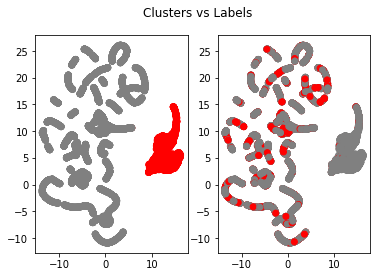

<Figure size 432x288 with 0 Axes>

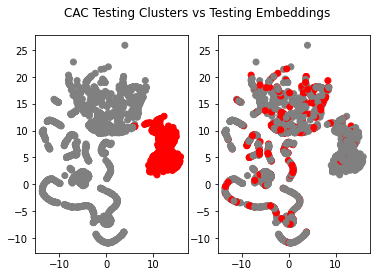

converged at itr:  1
Class Dist:  tensor(37868.1367)
Class Dist:  tensor(591978.5000)
KM Dist:  tensor(841.2560, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.1946e+09)
Epoch: 10 | Batch: 001 | Loss: -1194622208.000 | Rec-Loss: 511.946 | Dist-Loss: -1194622720.000
converged at itr:  1
Class Dist:  tensor(37254.0664)
Class Dist:  tensor(591439.5625)
KM Dist:  tensor(778.9780, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.1346e+09)
Epoch: 10 | Batch: 002 | Loss: -1134601600.000 | Rec-Loss: 589.204 | Dist-Loss: -1134602240.000
converged at itr:  1
Class Dist:  tensor(36599.9766)
Class Dist:  tensor(590875.3750)
KM Dist:  tensor(885.0650, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.0722e+09)
Epoch: 10 | Batch: 003 | Loss: -1072218944.000 | Rec-Loss: 542.611 | Dist-Loss: -1072219456.000
converged at itr:  1
Class Dist:  tensor(35989.0352)
Class Dist:  tensor(590167.5625)
KM Dist:  tensor(767.1522, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.1272e+09)
Epoch: 10 | Batch: 004 | Loss: -11271886

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(0.059504745540784325, -0.007652084703107178, 0.0, 0.0, 0.7286839944186858, 0.0, 0.0, 0.47473056350925136)
Epoch: 11 | NMI: 0.060 | ARI: -0.008 | Base_F1: 0.000 | Base_MCC: 0.000 | Base_AUC: 0.729 | CAC_F1: 0.000 | CAC_MCC: 0.000 | CAC_AUC: 0.475


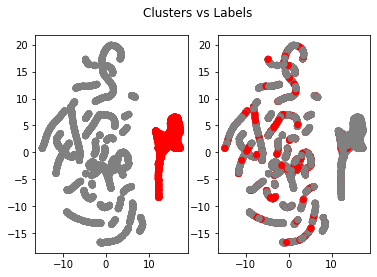

<Figure size 432x288 with 0 Axes>

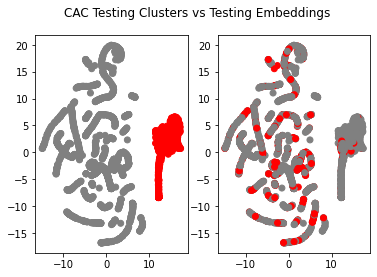

converged at itr:  1
Class Dist:  tensor(32866.4336)
Class Dist:  tensor(587385.4375)
KM Dist:  tensor(546.3921, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.1328e+09)
Epoch: 11 | Batch: 001 | Loss: -1132755840.000 | Rec-Loss: 515.702 | Dist-Loss: -1132756352.000
converged at itr:  1
Class Dist:  tensor(32380.1797)
Class Dist:  tensor(586678.9375)
KM Dist:  tensor(507.7660, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.1570e+09)
Epoch: 11 | Batch: 002 | Loss: -1156974592.000 | Rec-Loss: 500.094 | Dist-Loss: -1156975104.000
converged at itr:  1
Class Dist:  tensor(31894.9414)
Class Dist:  tensor(586174.7500)
KM Dist:  tensor(518.2422, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.1306e+09)
Epoch: 11 | Batch: 003 | Loss: -1130557440.000 | Rec-Loss: 522.227 | Dist-Loss: -1130557952.000
converged at itr:  1
Class Dist:  tensor(31408.9902)
Class Dist:  tensor(585730.1250)
KM Dist:  tensor(471.1472, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.1176e+09)
Epoch: 11 | Batch: 004 | Loss: -11175562

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(0.05818117932055462, -0.006699078960608282, 0.0, 0.0, 0.7293662156073313, 0.0, 0.0, 0.4663649510908272)
Epoch: 12 | NMI: 0.058 | ARI: -0.007 | Base_F1: 0.000 | Base_MCC: 0.000 | Base_AUC: 0.729 | CAC_F1: 0.000 | CAC_MCC: 0.000 | CAC_AUC: 0.466


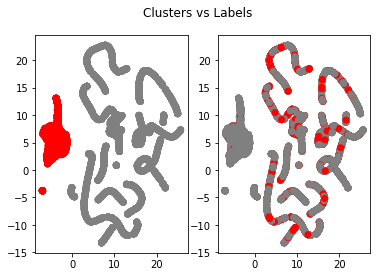

<Figure size 432x288 with 0 Axes>

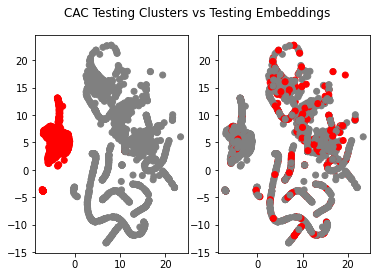

converged at itr:  1
Class Dist:  tensor(28852.1973)
Class Dist:  tensor(583105.5625)
KM Dist:  tensor(345.3383, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.1136e+09)
Epoch: 12 | Batch: 001 | Loss: -1113613312.000 | Rec-Loss: 485.047 | Dist-Loss: -1113613696.000
converged at itr:  1
Class Dist:  tensor(28428.8691)
Class Dist:  tensor(582666.1250)
KM Dist:  tensor(395.8846, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.0764e+09)
Epoch: 12 | Batch: 002 | Loss: -1076391936.000 | Rec-Loss: 506.434 | Dist-Loss: -1076392448.000
converged at itr:  1
Class Dist:  tensor(28051.0781)
Class Dist:  tensor(582132.5625)
KM Dist:  tensor(373.8580, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.1145e+09)
Epoch: 12 | Batch: 003 | Loss: -1114453376.000 | Rec-Loss: 540.960 | Dist-Loss: -1114453888.000
converged at itr:  1
Class Dist:  tensor(27669.6719)
Class Dist:  tensor(581803.9375)
KM Dist:  tensor(356.7392, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.1086e+09)
Epoch: 12 | Batch: 004 | Loss: -11085552

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(0.05952504702412468, -0.002966381747665965, 0.0, 0.0, 0.7200340474702402, 0.0, 0.0, 0.4863664772314356)
Epoch: 13 | NMI: 0.060 | ARI: -0.003 | Base_F1: 0.000 | Base_MCC: 0.000 | Base_AUC: 0.720 | CAC_F1: 0.000 | CAC_MCC: 0.000 | CAC_AUC: 0.486


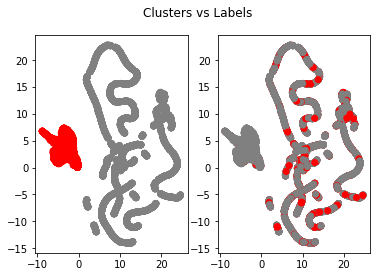

<Figure size 432x288 with 0 Axes>

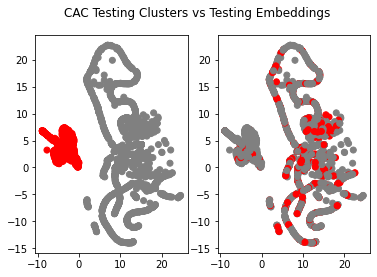

converged at itr:  1
Class Dist:  tensor(25600.0312)
Class Dist:  tensor(579293.8125)
KM Dist:  tensor(283.9273, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.0904e+09)
Epoch: 13 | Batch: 001 | Loss: -1090434304.000 | Rec-Loss: 485.565 | Dist-Loss: -1090434816.000
converged at itr:  1
Class Dist:  tensor(25287.6211)
Class Dist:  tensor(578824.5625)
KM Dist:  tensor(273.4409, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.1265e+09)
Epoch: 13 | Batch: 002 | Loss: -1126510976.000 | Rec-Loss: 509.418 | Dist-Loss: -1126511488.000
converged at itr:  1
Class Dist:  tensor(24960.0410)
Class Dist:  tensor(578520.3750)
KM Dist:  tensor(270.4605, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.0787e+09)
Epoch: 13 | Batch: 003 | Loss: -1078722432.000 | Rec-Loss: 515.217 | Dist-Loss: -1078722944.000
converged at itr:  1
Class Dist:  tensor(24629.5938)
Class Dist:  tensor(578081.6250)
KM Dist:  tensor(279.2349, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.0683e+09)
Epoch: 13 | Batch: 004 | Loss: -10683079

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(0.058521365914730034, -0.006147479564530425, 0.0, 0.0, 0.7287607556576212, 0.0, 0.0, 0.486993284981323)
Epoch: 14 | NMI: 0.059 | ARI: -0.006 | Base_F1: 0.000 | Base_MCC: 0.000 | Base_AUC: 0.729 | CAC_F1: 0.000 | CAC_MCC: 0.000 | CAC_AUC: 0.487


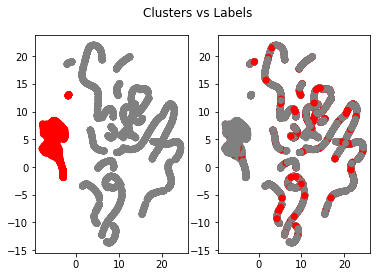

<Figure size 432x288 with 0 Axes>

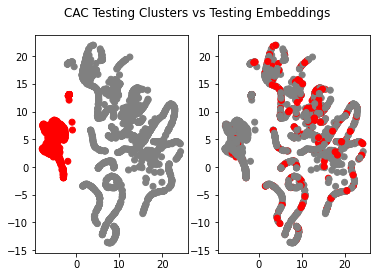

converged at itr:  1
Class Dist:  tensor(22915.5820)
Class Dist:  tensor(575801.3125)
KM Dist:  tensor(235.6421, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.0846e+09)
Epoch: 14 | Batch: 001 | Loss: -1084631936.000 | Rec-Loss: 492.304 | Dist-Loss: -1084632448.000
converged at itr:  1
Class Dist:  tensor(22614.8711)
Class Dist:  tensor(575494.6875)
KM Dist:  tensor(480.9127, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-9.8386e+08)
Epoch: 14 | Batch: 002 | Loss: -983859840.000 | Rec-Loss: 494.008 | Dist-Loss: -983860288.000
converged at itr:  1
Class Dist:  tensor(22352.5938)
Class Dist:  tensor(575130.3750)
KM Dist:  tensor(210.2617, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.1087e+09)
Epoch: 14 | Batch: 003 | Loss: -1108671616.000 | Rec-Loss: 485.627 | Dist-Loss: -1108672000.000
converged at itr:  1
Class Dist:  tensor(22079.4805)
Class Dist:  tensor(574726.1250)
KM Dist:  tensor(195.1882, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.0808e+09)
Epoch: 14 | Batch: 004 | Loss: -1080776576

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(0.05698791152800307, -0.004106778074687265, 0.0, 0.0, 0.7239811194604729, 0.0, 0.0, 0.5003606415604425)
Epoch: 15 | NMI: 0.057 | ARI: -0.004 | Base_F1: 0.000 | Base_MCC: 0.000 | Base_AUC: 0.724 | CAC_F1: 0.000 | CAC_MCC: 0.000 | CAC_AUC: 0.500


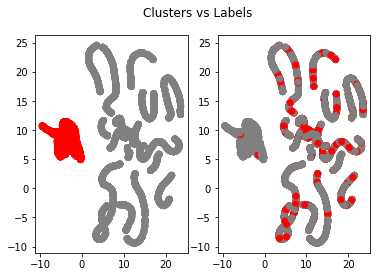

<Figure size 432x288 with 0 Axes>

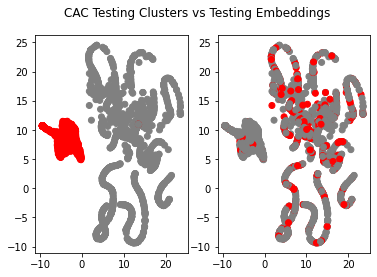

converged at itr:  1
Class Dist:  tensor(20658.9297)
Class Dist:  tensor(572513.6875)
KM Dist:  tensor(186.6428, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.0404e+09)
Epoch: 15 | Batch: 001 | Loss: -1040423552.000 | Rec-Loss: 499.416 | Dist-Loss: -1040424064.000
converged at itr:  1
Class Dist:  tensor(20443.0703)
Class Dist:  tensor(571975.6875)
KM Dist:  tensor(236.1375, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.1383e+09)
Epoch: 15 | Batch: 002 | Loss: -1138261632.000 | Rec-Loss: 505.805 | Dist-Loss: -1138262144.000
converged at itr:  1
Class Dist:  tensor(20212.2910)
Class Dist:  tensor(571657.)
KM Dist:  tensor(202.4108, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.0379e+09)
Epoch: 15 | Batch: 003 | Loss: -1037893952.000 | Rec-Loss: 501.915 | Dist-Loss: -1037894464.000
converged at itr:  1
Class Dist:  tensor(19984.7832)
Class Dist:  tensor(571360.3125)
KM Dist:  tensor(168.6034, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.0412e+09)
Epoch: 15 | Batch: 004 | Loss: -1041248256.0

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(0.057137943853698824, -0.006866176083966209, 0.0, 0.0, 0.7233225171145768, 0.0, 0.0, 0.48236081234284384)
Epoch: 16 | NMI: 0.057 | ARI: -0.007 | Base_F1: 0.000 | Base_MCC: 0.000 | Base_AUC: 0.723 | CAC_F1: 0.000 | CAC_MCC: 0.000 | CAC_AUC: 0.482


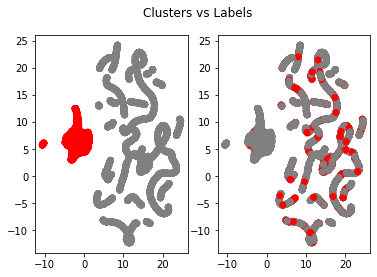

<Figure size 432x288 with 0 Axes>

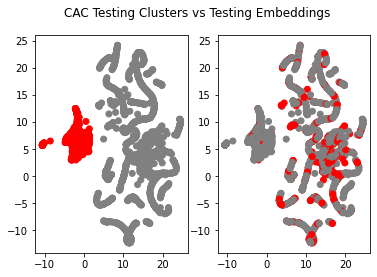

converged at itr:  1
Class Dist:  tensor(18740.4336)
Class Dist:  tensor(569460.7500)
KM Dist:  tensor(127.2824, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.0504e+09)
Epoch: 16 | Batch: 001 | Loss: -1050427264.000 | Rec-Loss: 463.794 | Dist-Loss: -1050427712.000
converged at itr:  1
Class Dist:  tensor(18544.9590)
Class Dist:  tensor(569050.7500)
KM Dist:  tensor(120.4738, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.0625e+09)
Epoch: 16 | Batch: 002 | Loss: -1062467456.000 | Rec-Loss: 499.637 | Dist-Loss: -1062467968.000
converged at itr:  1
Class Dist:  tensor(18348.5332)
Class Dist:  tensor(568864.4375)
KM Dist:  tensor(126.1696, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.0419e+09)
Epoch: 16 | Batch: 003 | Loss: -1041865920.000 | Rec-Loss: 507.708 | Dist-Loss: -1041866432.000
converged at itr:  1
Class Dist:  tensor(18164.8438)
Class Dist:  tensor(568442.4375)
KM Dist:  tensor(113.6718, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.0605e+09)
Epoch: 16 | Batch: 004 | Loss: -10605011

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(0.057780407148847204, -0.002803508562838406, 0.0, 0.0, 0.7230259189546664, 0.0, 0.0, 0.48774636269821664)
Epoch: 17 | NMI: 0.058 | ARI: -0.003 | Base_F1: 0.000 | Base_MCC: 0.000 | Base_AUC: 0.723 | CAC_F1: 0.000 | CAC_MCC: 0.000 | CAC_AUC: 0.488


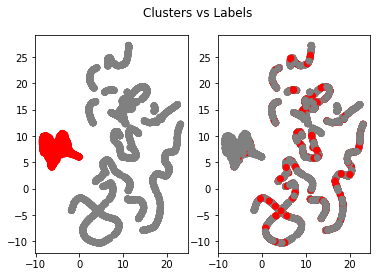

<Figure size 432x288 with 0 Axes>

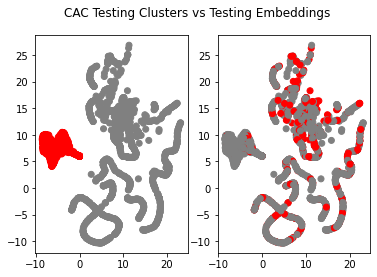

converged at itr:  1
Class Dist:  tensor(17101.6328)
Class Dist:  tensor(566445.2500)
KM Dist:  tensor(160.0955, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.0105e+09)
Epoch: 17 | Batch: 001 | Loss: -1010530688.000 | Rec-Loss: 476.925 | Dist-Loss: -1010531136.000
converged at itr:  1
Class Dist:  tensor(16918.2637)
Class Dist:  tensor(566164.6875)
KM Dist:  tensor(197.7848, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-9.9202e+08)
Epoch: 17 | Batch: 002 | Loss: -992022464.000 | Rec-Loss: 472.368 | Dist-Loss: -992022912.000
converged at itr:  1
Class Dist:  tensor(16743.2559)
Class Dist:  tensor(565835.0625)
KM Dist:  tensor(127.2326, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.0108e+09)
Epoch: 17 | Batch: 003 | Loss: -1010817024.000 | Rec-Loss: 497.776 | Dist-Loss: -1010817536.000
converged at itr:  1
Class Dist:  tensor(16574.8320)
Class Dist:  tensor(565508.0625)
KM Dist:  tensor(87.2426, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.0384e+09)
Epoch: 17 | Batch: 004 | Loss: -1038404480.

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(0.057475550934110956, -0.006319916493962338, 0.0, 0.0, 0.7182530958852342, 0.0, 0.0, 0.4817757917762823)
Epoch: 18 | NMI: 0.057 | ARI: -0.006 | Base_F1: 0.000 | Base_MCC: 0.000 | Base_AUC: 0.718 | CAC_F1: 0.000 | CAC_MCC: 0.000 | CAC_AUC: 0.482


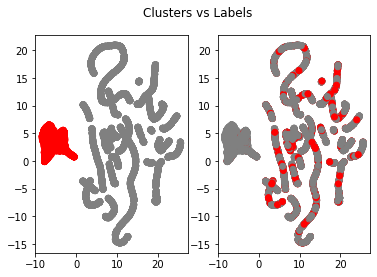

<Figure size 432x288 with 0 Axes>

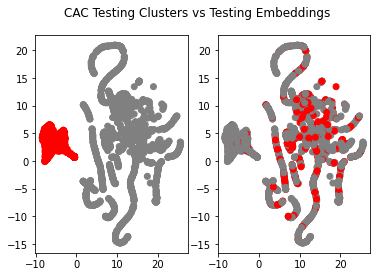

converged at itr:  1
Class Dist:  tensor(15692.6113)
Class Dist:  tensor(563937.3125)
KM Dist:  tensor(103.3703, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.0774e+09)
Epoch: 18 | Batch: 001 | Loss: -1077436032.000 | Rec-Loss: 465.460 | Dist-Loss: -1077436416.000
converged at itr:  1
Class Dist:  tensor(15548.0654)
Class Dist:  tensor(563675.3750)
KM Dist:  tensor(84.4414, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.0416e+09)
Epoch: 18 | Batch: 002 | Loss: -1041552896.000 | Rec-Loss: 486.414 | Dist-Loss: -1041553408.000
converged at itr:  1
Class Dist:  tensor(15393.0986)
Class Dist:  tensor(563414.3125)
KM Dist:  tensor(157.4906, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.0013e+09)
Epoch: 18 | Batch: 003 | Loss: -1001255616.000 | Rec-Loss: 469.409 | Dist-Loss: -1001256128.000
converged at itr:  1
Class Dist:  tensor(15247.2891)
Class Dist:  tensor(563107.8750)
KM Dist:  tensor(76.7323, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.0464e+09)
Epoch: 18 | Batch: 004 | Loss: -1046406400

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(0.05666632208916157, -0.006126140895096818, 0.0, 0.0, 0.7233756595107629, 0.0, 0.0, 0.48251660586328693)
Epoch: 19 | NMI: 0.057 | ARI: -0.006 | Base_F1: 0.000 | Base_MCC: 0.000 | Base_AUC: 0.723 | CAC_F1: 0.000 | CAC_MCC: 0.000 | CAC_AUC: 0.483


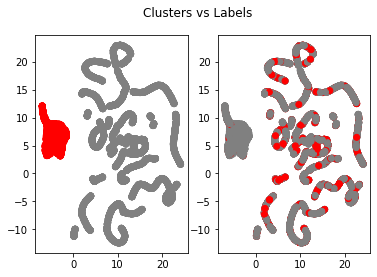

<Figure size 432x288 with 0 Axes>

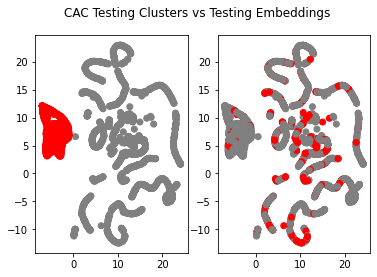

converged at itr:  1
Class Dist:  tensor(14455.0498)
Class Dist:  tensor(561465.6250)
KM Dist:  tensor(66.5328, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.0329e+09)
Epoch: 19 | Batch: 001 | Loss: -1032883712.000 | Rec-Loss: 484.036 | Dist-Loss: -1032884224.000
converged at itr:  1
Class Dist:  tensor(14328.6699)
Class Dist:  tensor(561265.4375)
KM Dist:  tensor(78.0796, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.0585e+09)
Epoch: 19 | Batch: 002 | Loss: -1058495168.000 | Rec-Loss: 479.285 | Dist-Loss: -1058495680.000
converged at itr:  1
Class Dist:  tensor(14202.3955)
Class Dist:  tensor(560990.0625)
KM Dist:  tensor(66.1668, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.0511e+09)
Epoch: 19 | Batch: 003 | Loss: -1051147328.000 | Rec-Loss: 467.472 | Dist-Loss: -1051147776.000
converged at itr:  1
Class Dist:  tensor(14071.2539)
Class Dist:  tensor(560776.5000)
KM Dist:  tensor(79.3649, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.0155e+09)
Epoch: 19 | Batch: 004 | Loss: -1015462208.0

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(0.057228455155607795, -0.005212556242490773, 0.0, 0.0, 0.725289239981977, 0.0, 0.0, 0.47640477609337073)
Epoch: 20 | NMI: 0.057 | ARI: -0.005 | Base_F1: 0.000 | Base_MCC: 0.000 | Base_AUC: 0.725 | CAC_F1: 0.000 | CAC_MCC: 0.000 | CAC_AUC: 0.476


/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [97]:
model.args.alpha = 4
# model.clustering = initial_clustering
reducer = umap.UMAP()
for e in range(args.epoch):
    # Print training set
    if e%1 == 0:
        out = model.autoencoder(torch.FloatTensor(np.array(X_train)).to(args.device), latent=True)
        cluster_id = model.clustering.update_assign(out.cpu().detach().numpy())
        X2 = reducer.fit_transform(out.cpu().detach().numpy())
#         X2 = out.cpu().detach().numpy()
#         X_centers = reducer.transform(model.clustering.clusters)

        c_clusters = [color[int(cluster_id[i])] for i in range(len(cluster_id))]
        c_labels = [color[int(y_train[i])] for i in range(len(cluster_id))]
        # plt.scatter(latent_X[:,0], latent_X[:,1], color=c_train); plt.show()

        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Clusters vs Labels')
        ax1.scatter(X2[:,0], X2[:,1], color=c_clusters)
#         ax1.plot(X_centers[0], marker='x', markersize=3, color="green")
#         ax1.plot(X_centers[1], marker='x', markersize=3, color="green")

        ax2.scatter(X2[:,0], X2[:,1], color=c_labels)
        plt.show()

        # Print testset
        out = model.autoencoder(torch.FloatTensor(np.array(X_test)).to(args.device), latent=True)
        test_cluster_id = model.clustering.update_assign(out.cpu().detach().numpy())
        X_t = reducer.transform(out.cpu().detach().numpy())
#         X_t = out.cpu().detach().numpy()

        c_clusters = [color[int(test_cluster_id[i])] for i in range(len(test_cluster_id))]
        c_test = [color[int(y_test[i])] for i in range(len(y_test))]

        figure = plt.figure()
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('CAC Testing Clusters vs Testing Embeddings')
        ax1.scatter(X_t[:,0], X_t[:,1], color=c_clusters)
        ax2.scatter(X_t[:,0], X_t[:,1], color=c_test)
        plt.show()

    model.train()
    model.fit(e, train_loader)

    model.eval()
    out = evaluate(model, test_loader)  # evaluation on the test_loader
    print(out)
    if len(out) > 2:
        NMI, ARI, base_f1, base_mcc, base_auc, cac_f1, cac_mcc, cac_auc = out
    else:
        NMI, ARI = out
    nmi_list.append(NMI)
    ari_list.append(ARI)

    print('Epoch: {:02d} | NMI: {:.3f} | ARI: {:.3f} | Base_F1: {:.3f} | Base_MCC: {:.3f} | Base_AUC: {:.3f} | CAC_F1: {:.3f} | CAC_MCC: {:.3f} | CAC_AUC: {:.3f}'.format(
            e+1, NMI, ARI, base_f1, base_mcc, base_auc, cac_f1, cac_mcc, cac_auc))


In [ ]:
params['n_clusters'] = 3
args = parameters(params)
datasets = ['titanic', 'magic', 'creditcard', 'adult', 'diabetes', 'cic', 'synthetic', 'new_synthetic']

In [ ]:
if args.dataset in datasets:
    base_dir = "../../CAC_code/data"
    print("Loading Dataset:", args.dataset)
    if args.dataset == "synthetic":
        n_feat = 45
        X, y = create_imbalanced_data_clusters(n_samples=500, n_clusters=2, n_features = n_feat, inner_class_sep=0.2, seed=0)
        X = pd.DataFrame(X)
        y = pd.DataFrame(y)
        args.input_dim = n_feat

    elif args.dataset == "paper_synthetic":
        n_feat = 100
        X, y = paper_synthetic(10000)
        X = pd.DataFrame(X)
        y = pd.DataFrame(y)
        args.input_dim = n_feat

    else:
        X, y = get_dataset(args.dataset, base_dir)
        args.input_dim = X.shape[1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)

    X_train_data_loader = list(zip(X_train.astype(np.float32), y_train))
    X_test_data_loader  = list(zip(X_test.astype(np.float32), y_test))

    train_loader = torch.utils.data.DataLoader(X_train_data_loader,
        batch_size=args.batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(X_test_data_loader, 
        batch_size=args.batch_size, shuffle=False)

elif args.dir == "../datasets/mnist":
    # Load data
    transformer = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,),
                                                           (0.3081,))])

    train_set = datasets.MNIST(args.dir, train=True, download=True, transform=transformer)
    test_set  = datasets.MNIST(args.dir, train=False, transform=transformer)
    train_limit = list(range(0, len(train_set))) if not args.test_run else list(range(0, 500))    
    test_limit  = list(range(0, len(test_set)))  if not args.test_run else list(range(0, 500))    

    train_loader = torch.utils.data.DataLoader(Subset(train_set, train_limit),
        batch_size=args.batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(Subset(test_set, test_limit), 
        batch_size=args.batch_size, shuffle=False)

In [ ]:
model3 = DCN(args)
rec_loss_list = model3.pretrain(train_loader, epoch=args.pre_epoch)
pre_trained_AE = model3.autoencoder
# model.autoencoder = pre_trained_AE
# initial_clustering = model.clustering
# model.pre_cluster(train_loader)
# model.pre_cluster(train_loader)
nmi_list = []
ari_list = []

In [ ]:
model3.args = args
# model.clustering = initial_clustering
reducer = umap.UMAP()
for e in range(args.epoch):
    # Show training set
    if e%1 == 0:
        out = model.autoencoder(torch.FloatTensor(np.array(X_train)).to(args.device), latent=True)
        cluster_id = model.clustering.update_assign(out.cpu().detach().numpy())
        X2 = reducer.fit_transform(out.cpu().detach().numpy())

#         X_centers = reducer.transform(model.clustering.clusters)

        c_clusters = [color[int(cluster_id[i])] for i in range(len(cluster_id))]
        c_labels = [color[int(y_train[i])] for i in range(len(cluster_id))]
        # plt.scatter(latent_X[:,0], latent_X[:,1], color=c_train); plt.show()

        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Clusters vs Labels')
        ax1.scatter(X2[:,0], X2[:,1], color=c_clusters)
#         ax1.plot(X_centers[0], marker='x', markersize=3, color="green")
#         ax1.plot(X_centers[1], marker='x', markersize=3, color="green")

        ax2.scatter(X2[:,0], X2[:,1], color=c_labels)
        plt.show()

        # Print testset
        out = model.autoencoder(torch.FloatTensor(np.array(X_test)).to(args.device), latent=True)
        test_cluster_id = model.clustering.update_assign(out.cpu().detach().numpy())
        X_t = reducer.transform(out.cpu().detach().numpy())

        c_clusters = [color[int(test_cluster_id[i])] for i in range(len(test_cluster_id))]
        c_test = [color[int(y_test[i])] for i in range(len(y_test))]

        figure = plt.figure()
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('CAC Testing Clusters vs Testing Embeddings')
        ax1.scatter(X_t[:,0], X_t[:,1], color=c_clusters)
        ax2.scatter(X_t[:,0], X_t[:,1], color=c_test)
        plt.show()

    model.train()
    model.fit(e, train_loader)

    model.eval()
    NMI, ARI, base_f1, base_auc, cac_f1, cac_auc = evaluate(model, test_loader)  # evaluation on the test_loader
    nmi_list.append(NMI)
    ari_list.append(ARI)

    print('Epoch: {:02d} | NMI: {:.3f} | ARI: {:.3f} | Base_F1: {:.3f} | Base_AUC: {:.3f} | CAC_F1: {:.3f} | CAC_F1: {:.3f}'.format(
        e+1, NMI, ARI, base_f1, base_auc, cac_f1, cac_auc))
